# AP-1 Peak Calling

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Preprocessing

In [28]:
# file directories
workingDirectory = '/home/jenhan/analysis/ap1_analysis/'
peakDirectory = '/home/jenhan/analysis/ap1_analysis/peak_files/'
scratchDirectory = '/home/jenhan/analysis/ap1_analysis/scratch'
logFilePath = '/home/jenhan/analysis/ap1_analysis/log_files/'
tagDirPath = '/home/jenhan/analysis/ap1_analysis/tag_directories/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'

os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
if not os.path.isfile("nameMapping.tsv"):
    nameMappingFile = open("nameMapping.tsv", "w")
    for f in os.listdir(logFilePath):
        rootName = f.replace('.fastq.mm10.bowtie2.log','')
        nameMappingFile.write(rootName + '\t' + rootName + '\n')
    nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.lower().replace('-1h','').replace('dsgfa-','')
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments


### read in log files ###

# create data frame summarizing mapping quality logs
# _sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
_tagsPerPosition = []
for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
        
    rootName = logFile.replace('.fastq.mm10.bowtie2.log','')
#     sampleName = originalName_cleanedName_dict[rootName]
    
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _originalNames.append(rootName)
#     _sampleNames.append(sampleName)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _tagsPerPosition.append(float(data[5].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']

# read in pbc values
sampleName_pbc_dict = {} # {sampleName: pbc valeue}
# with open ("ap1_pbc.tsv") as f:
#     data = f.readlines()
# for line in data:
#     tokens = line.strip().split('\t')
#     sampleName = tokens[0]
#     pbcValue = float(tokens[1])
#     sampleName_pbc_dict[sampleName] = pbcValue
# mappingStats_frame['pbc'] = [sampleName_pbc_dict[x] for x in mappingStats_frame['originalName']]
    


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

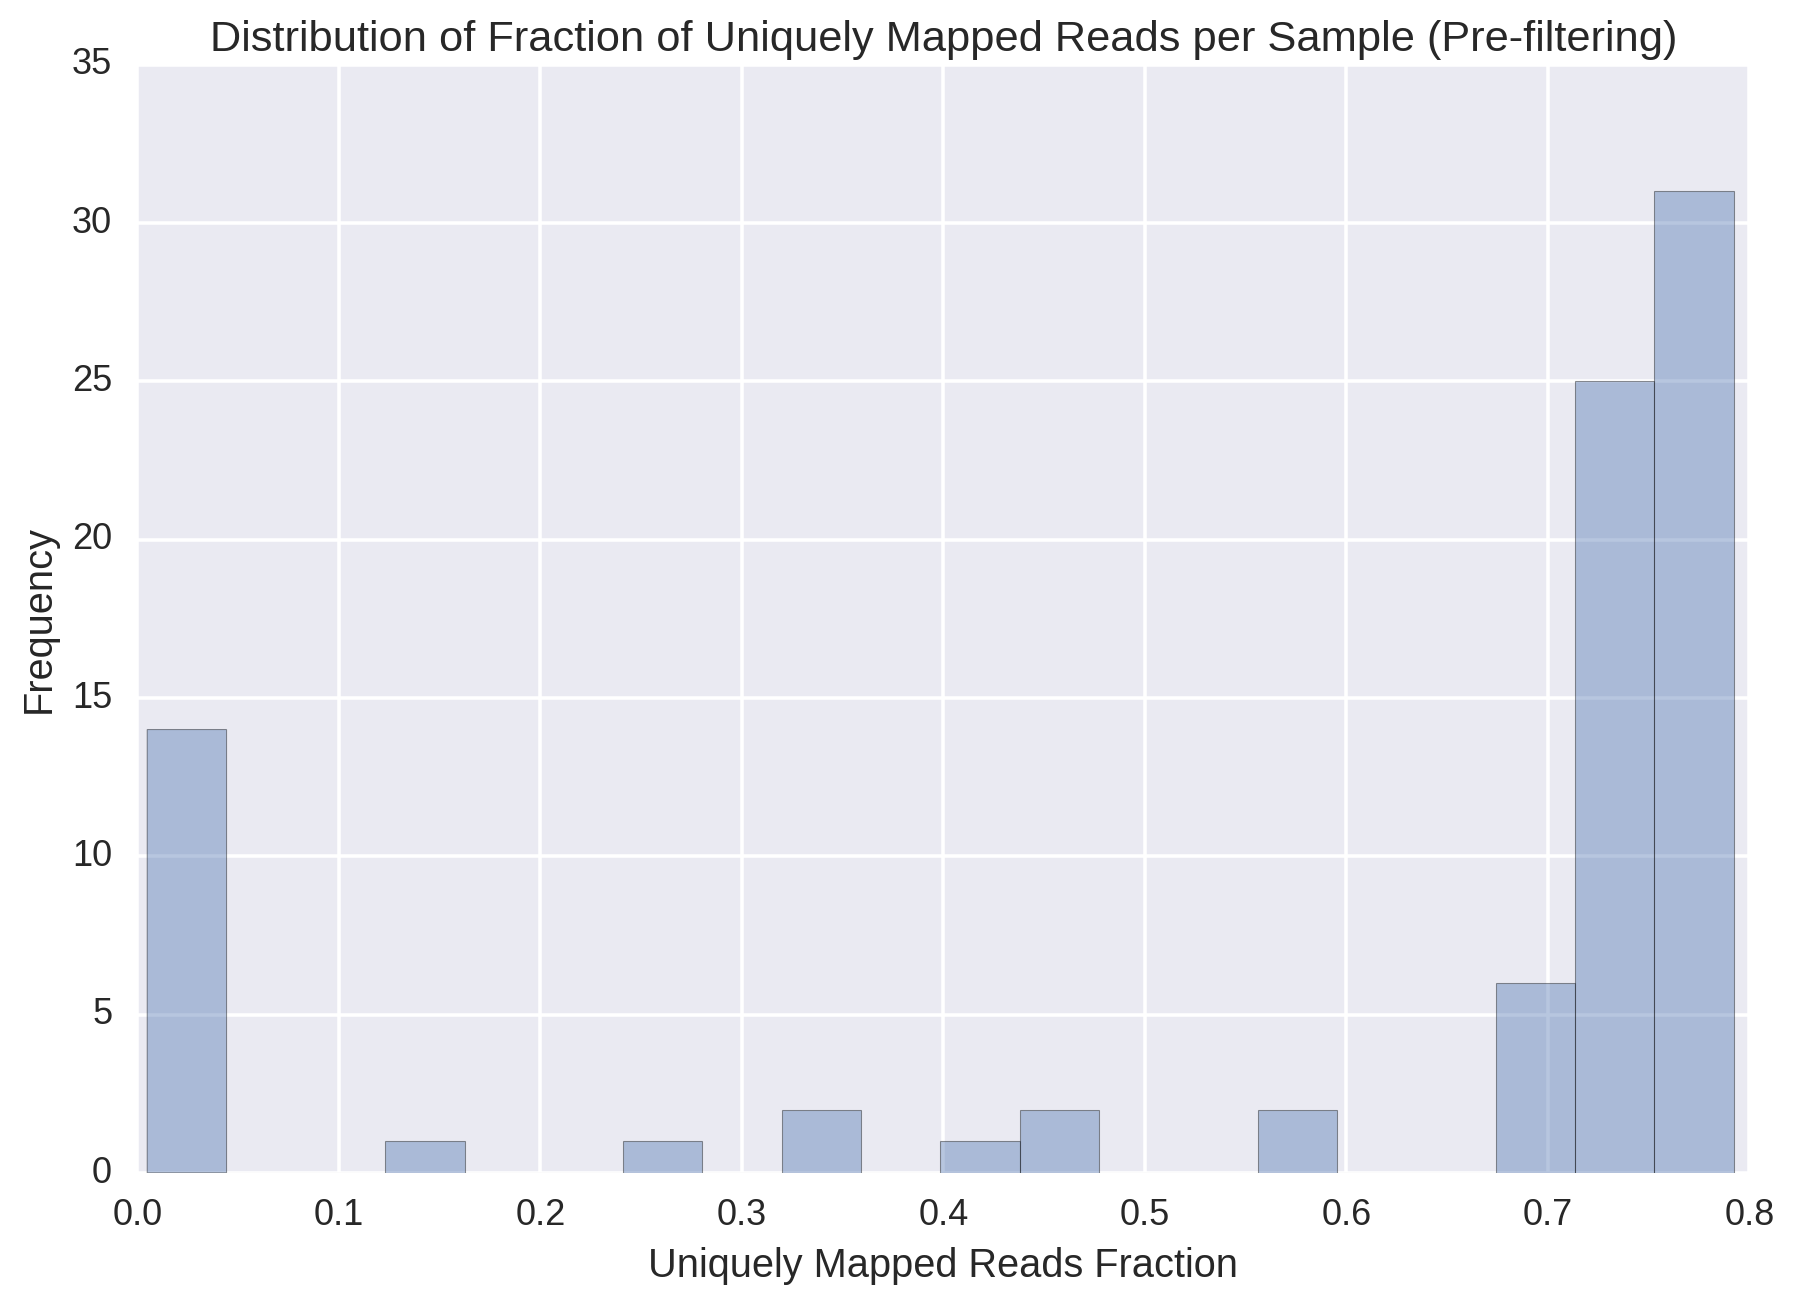

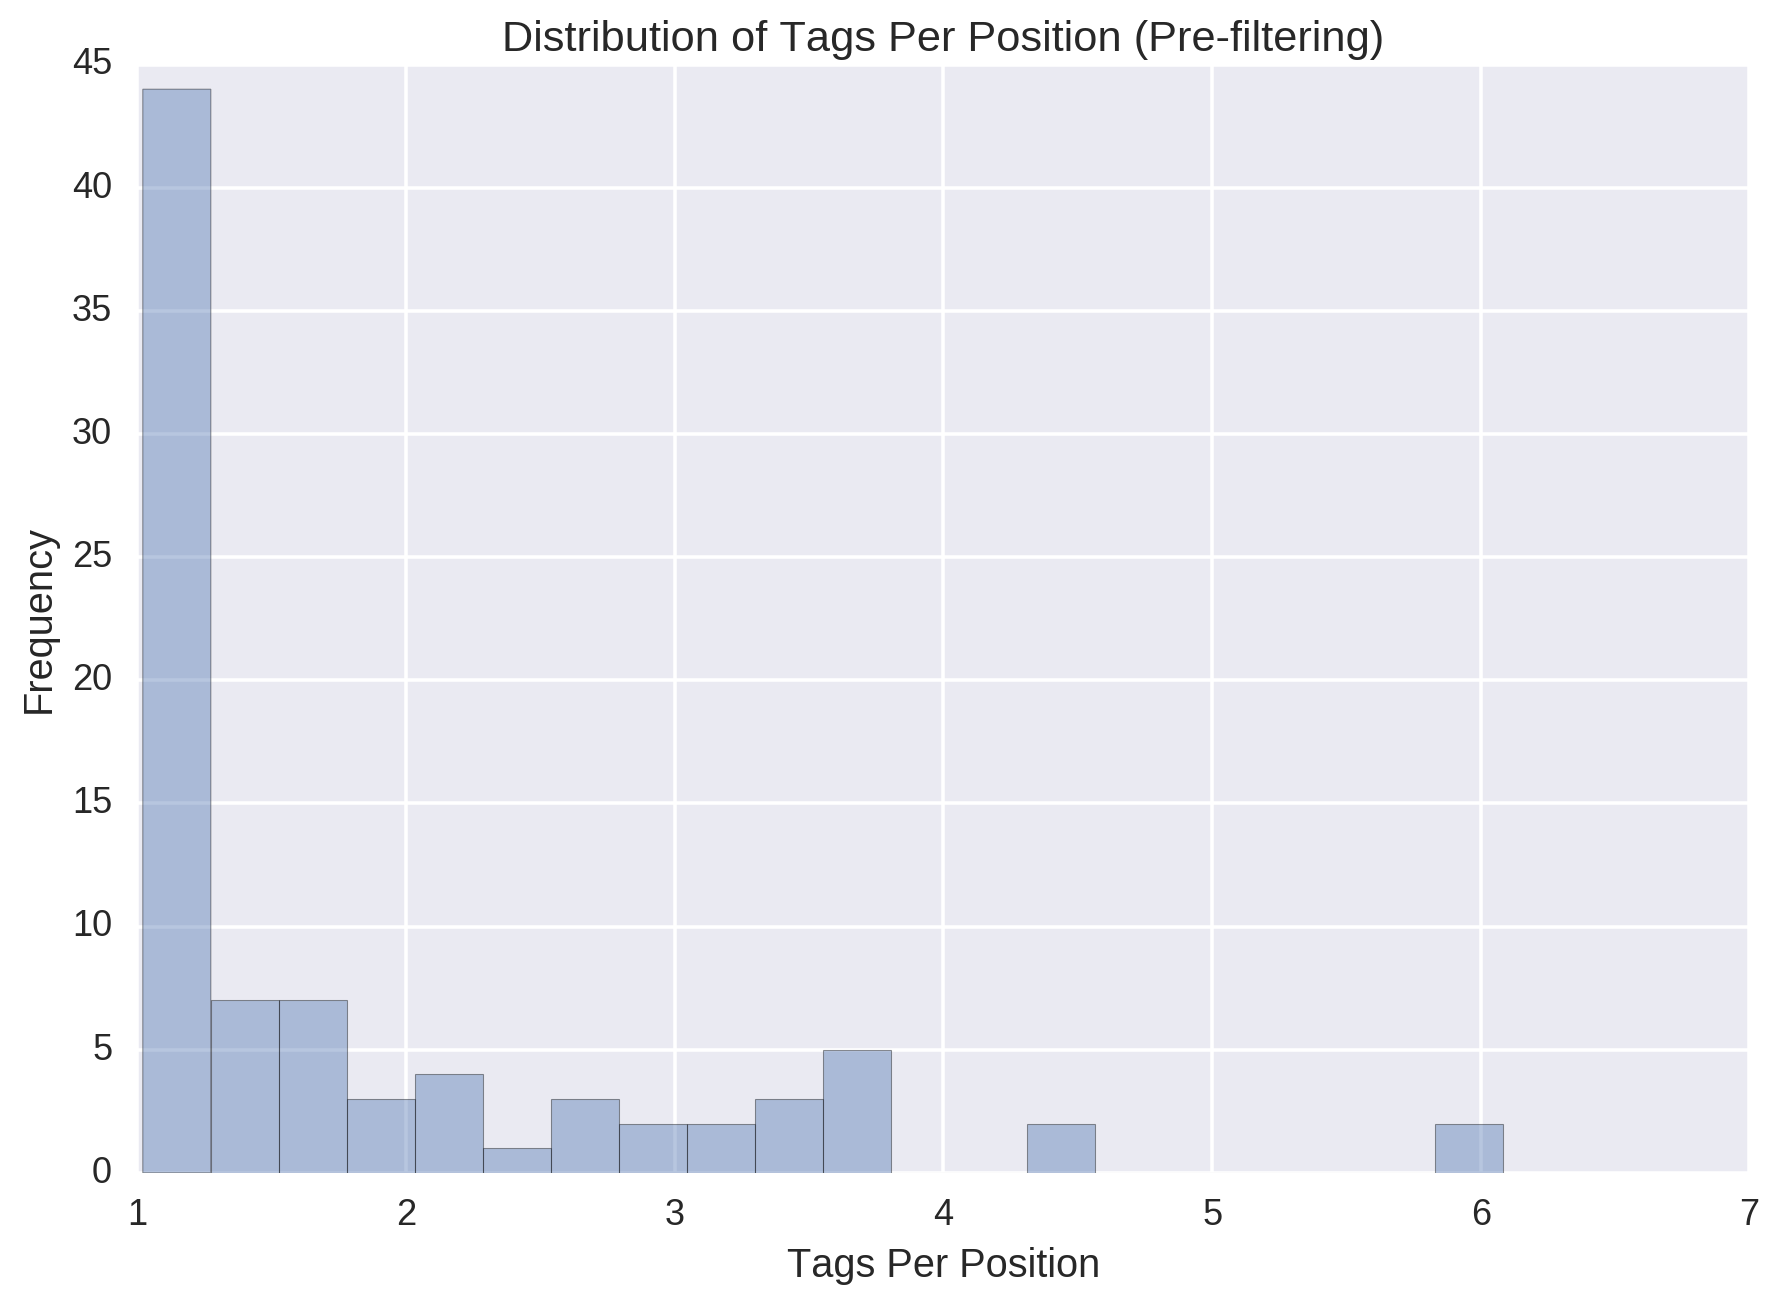

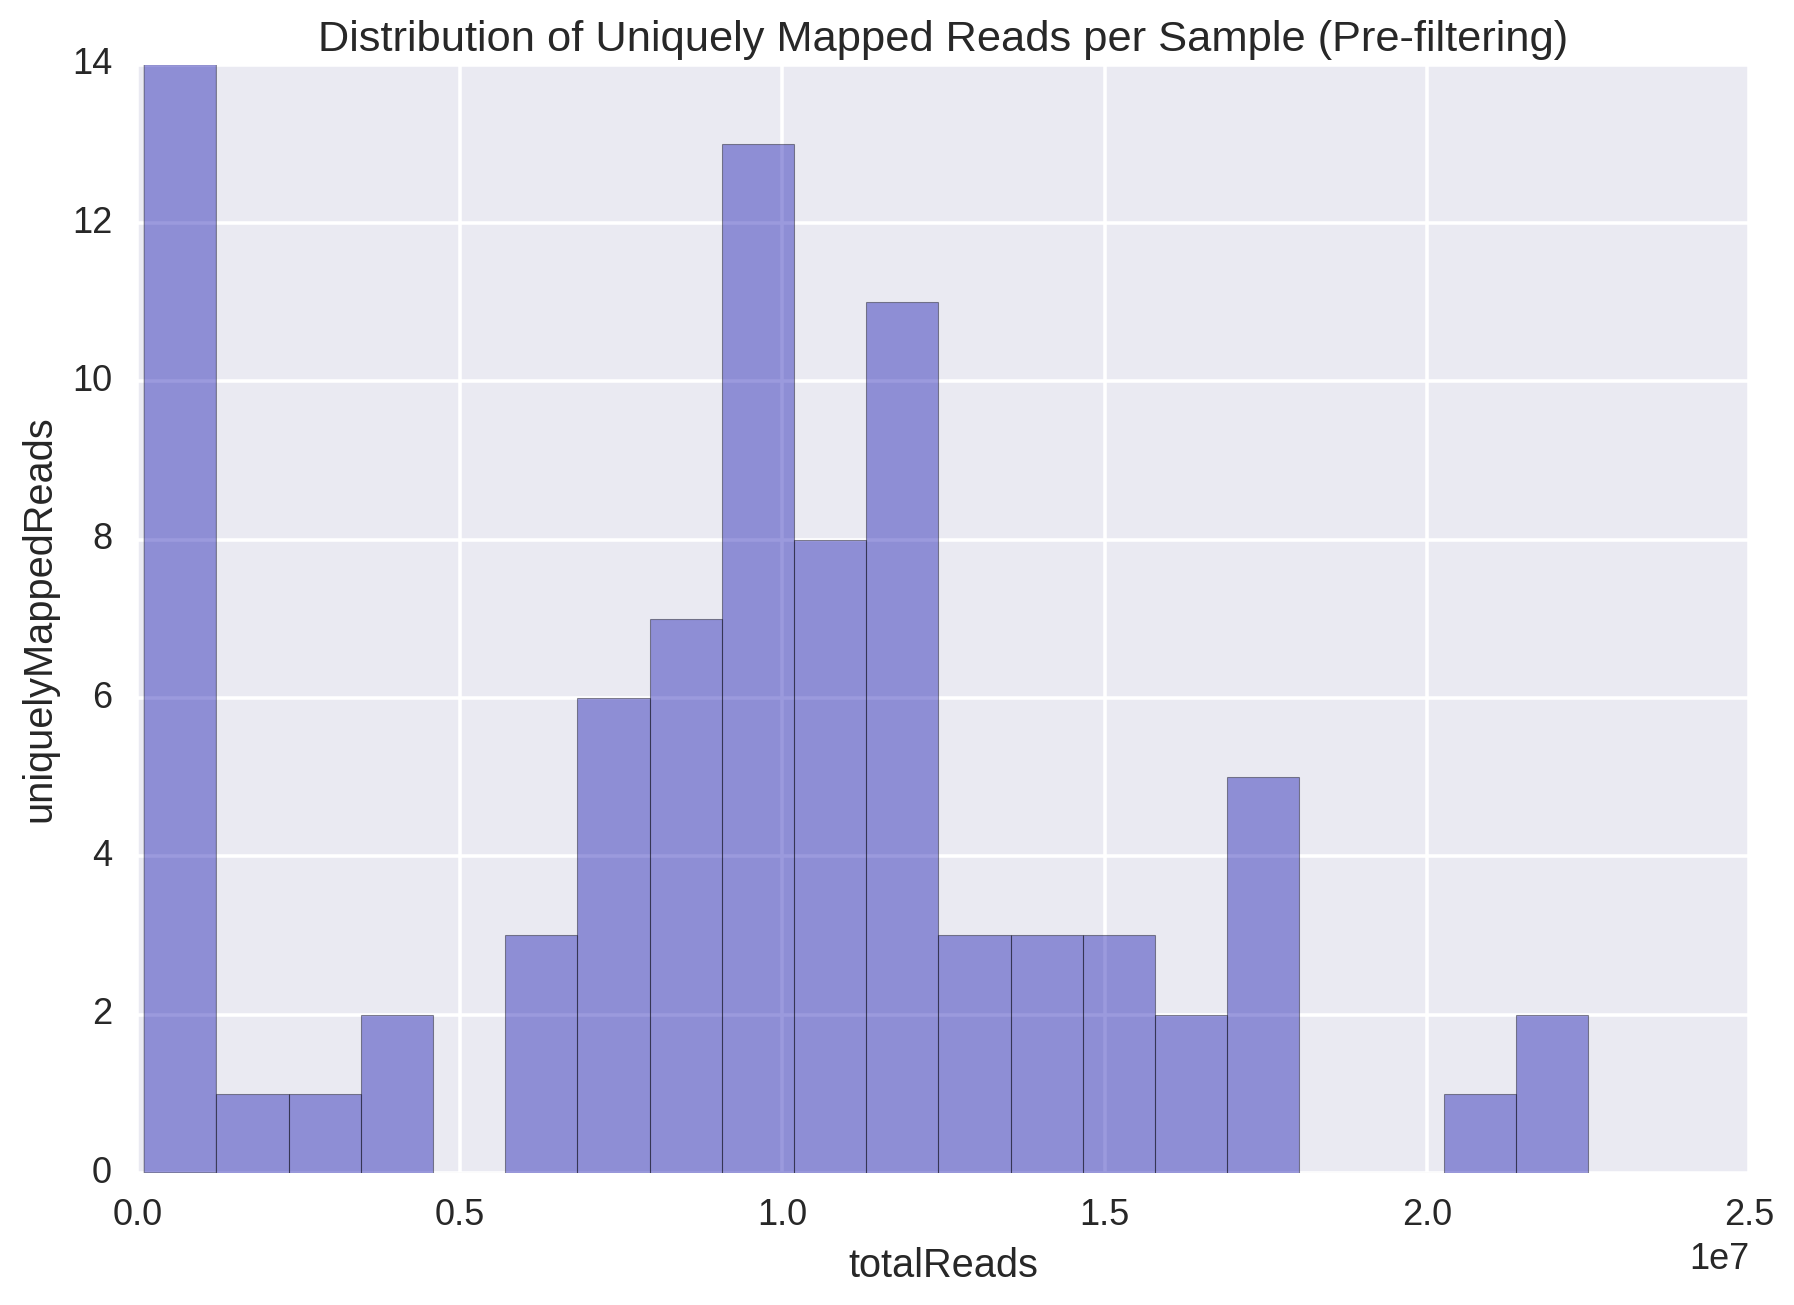

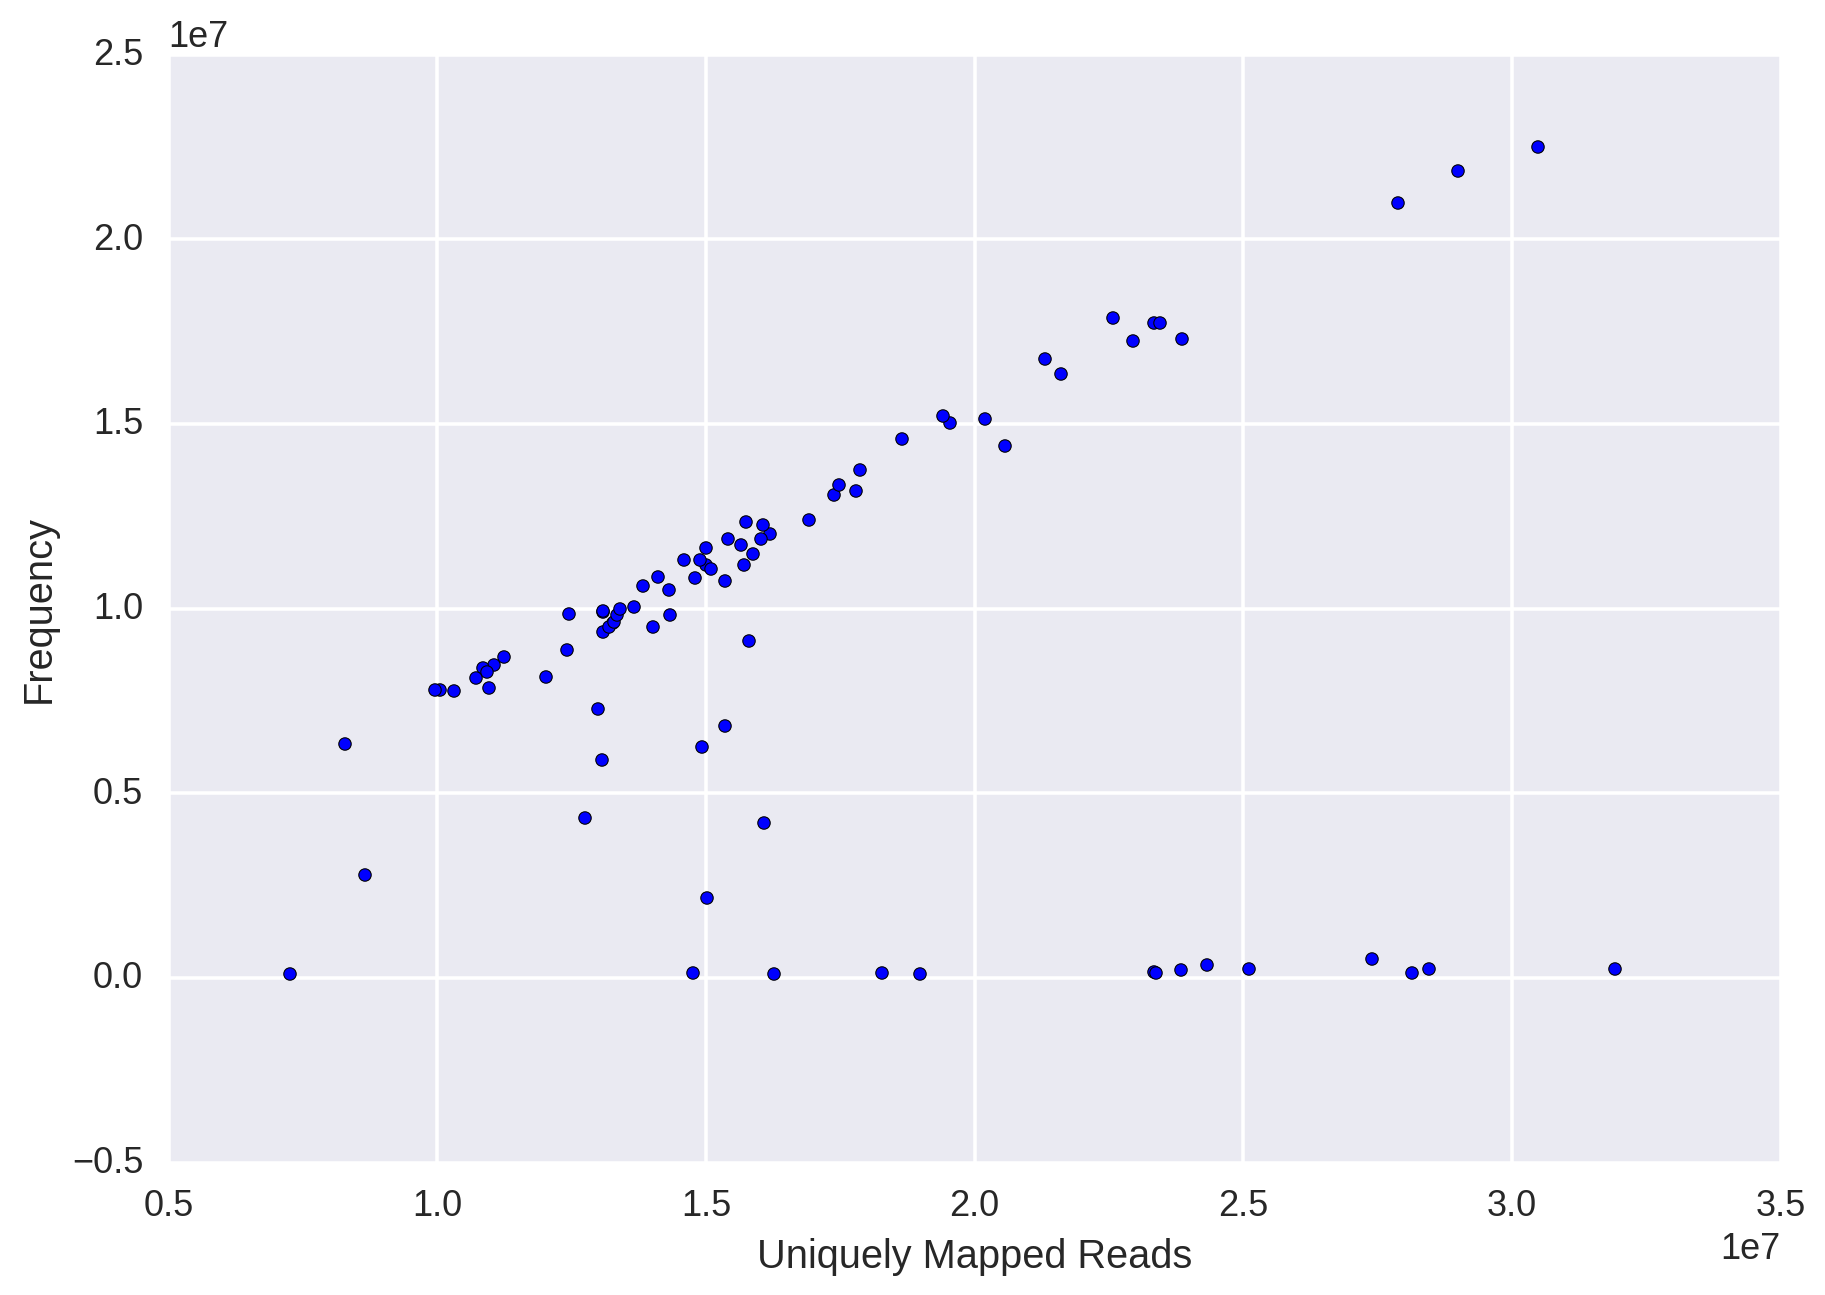

In [29]:
# plot distribution of uniquely mapped reads
sns.distplot(mapping_summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(mapping_summary_frame['tagsPerPosition'], bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
# sns.distplot(summary_frame['pbc'], bins=20, kde=False)
# plt.title('Distribution of PBC (Pre-filtering)')
# plt.xlabel('PBC')
# plt.ylabel('Frequency')
# plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(mapping_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()


plt.scatter(x = mapping_summary_frame['totalReads'].astype(float).values, y=mapping_summary_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [30]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.5
uniquelyMappedReadThreshold = 7500000
# pbcThreshold=0.5
# spotThreshold = 0.005

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]
# #filter on PBC
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['pbc'] >= pbcThreshold]
# print(filtered_summary_frame.shape)
# #filter on spot
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['spot'] >= spotThreshold]
# print(filtered_summary_frame.shape)

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] + '_' + filtered_summary_frame['factor'] + '_' + filtered_summary_frame["simpleTreatment"]).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["originalName"])) # {newName:originalName}

sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 



Number of Samples: 85
Number of discarded samples: 23
Number of Samples remaining after filtering: 62


<function xticks at 0x7fa58e734158>


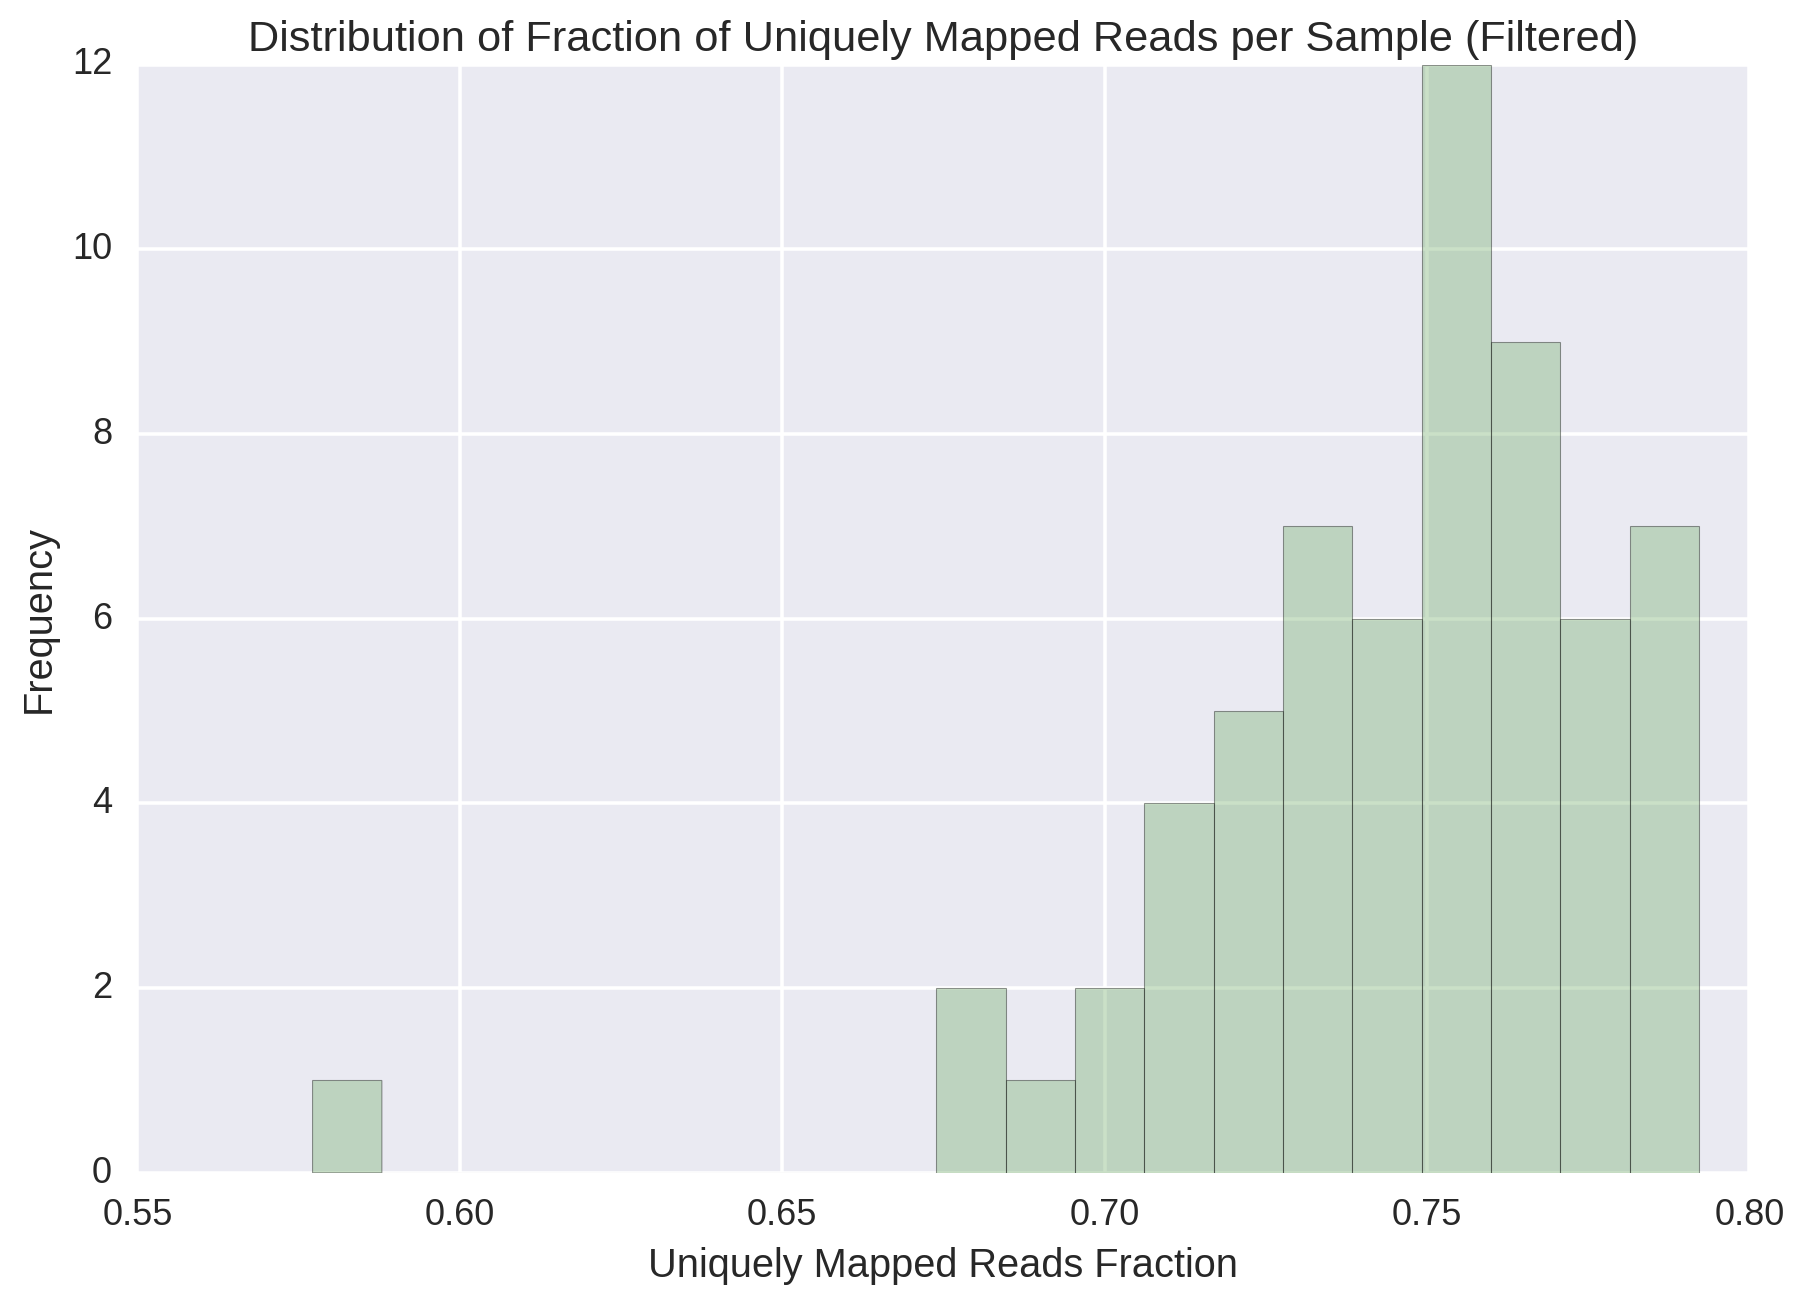

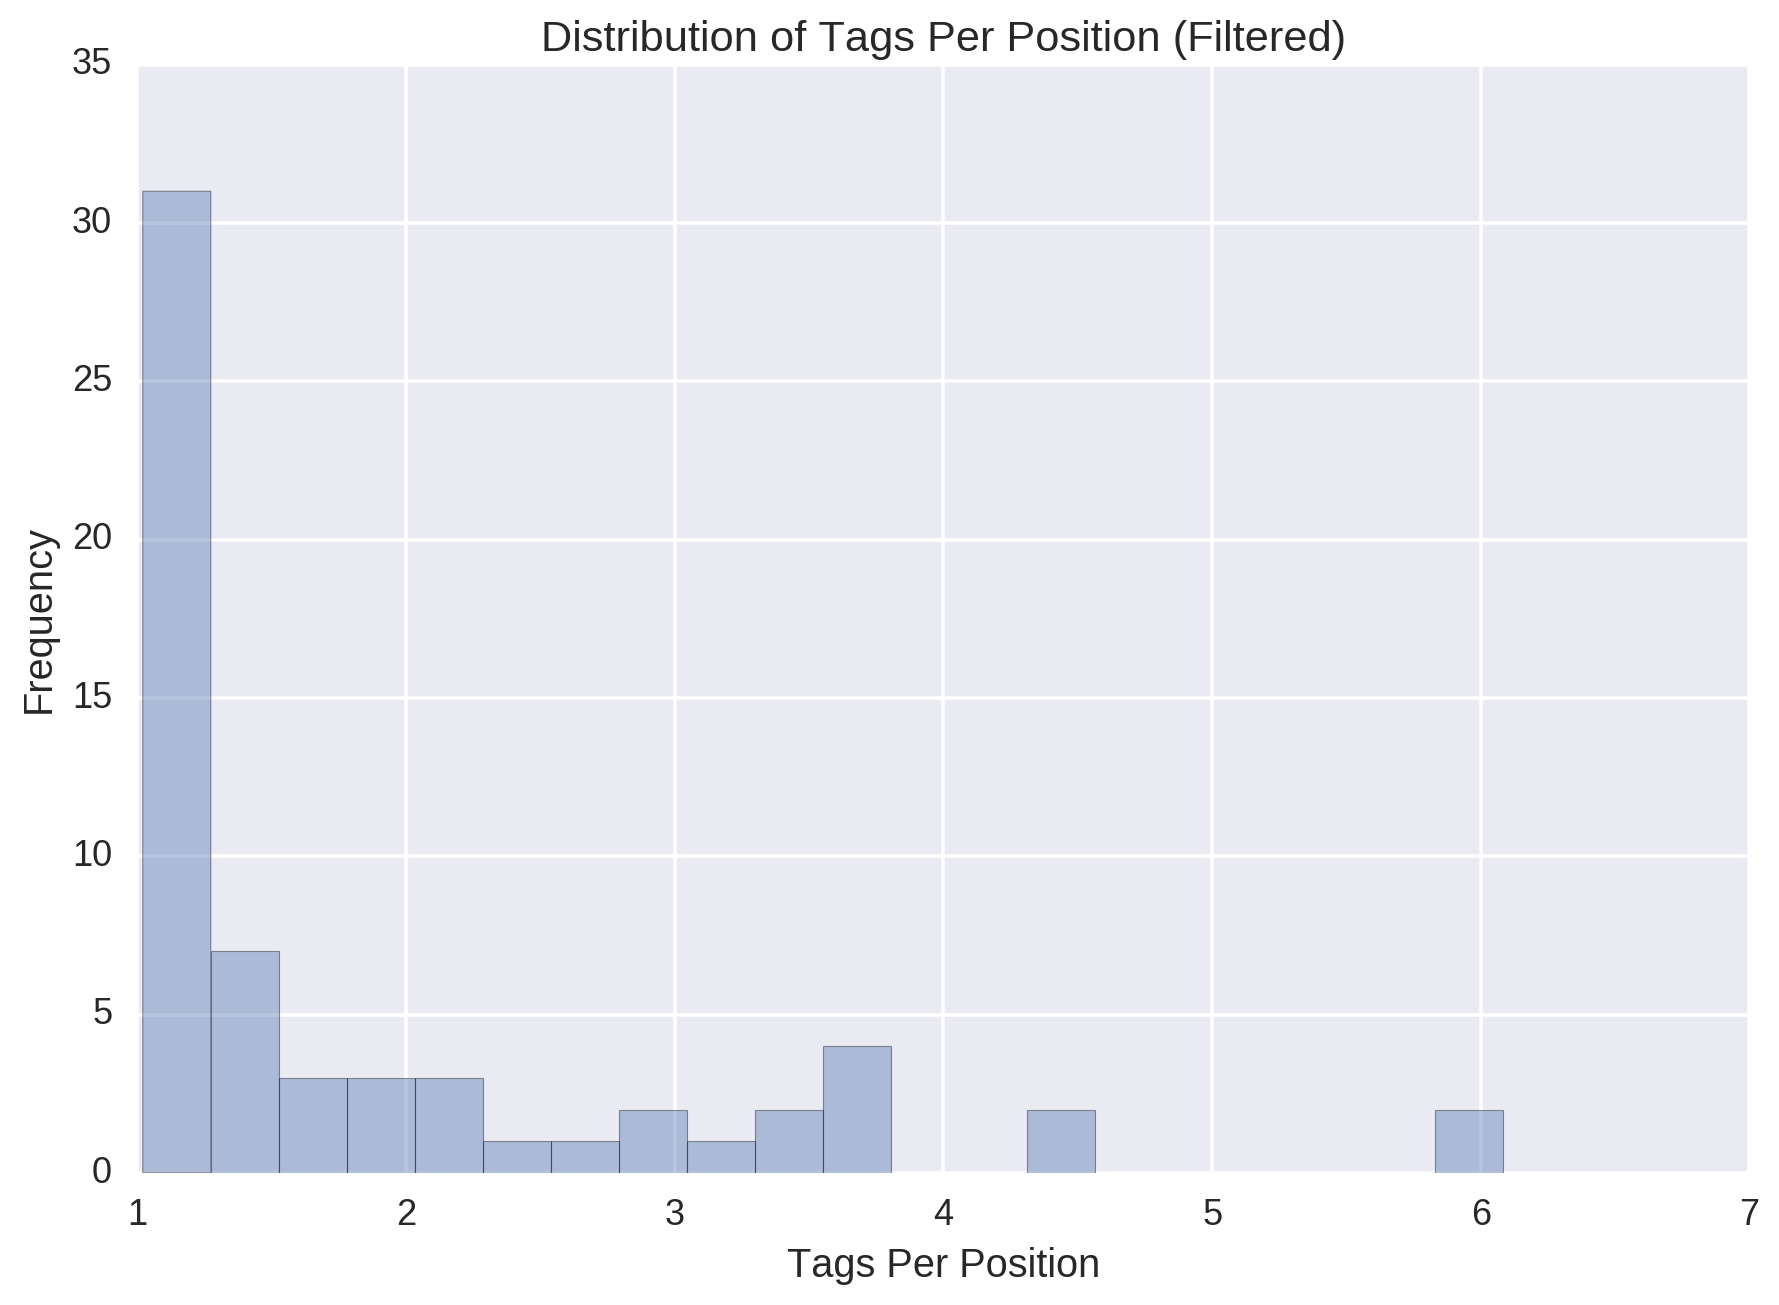

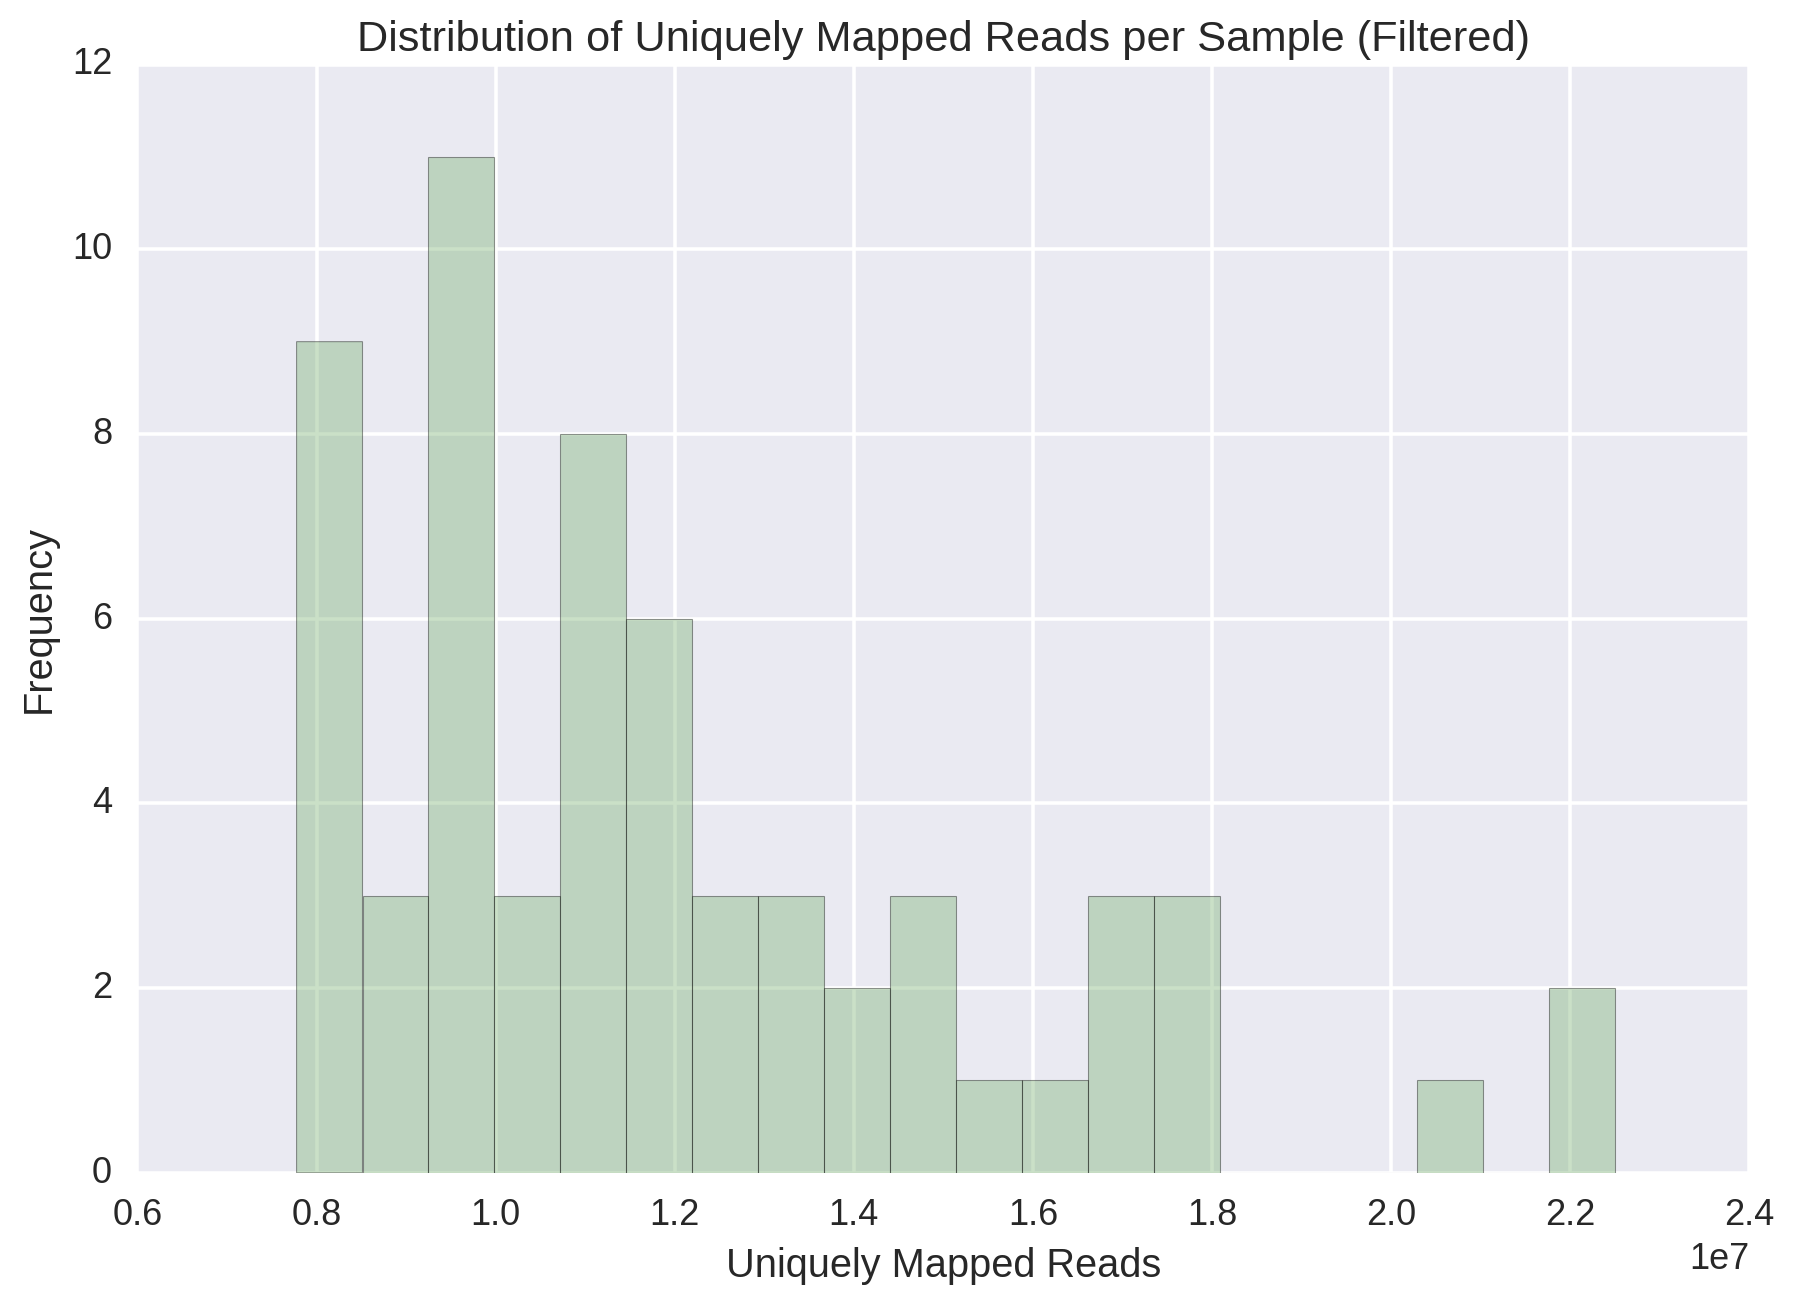

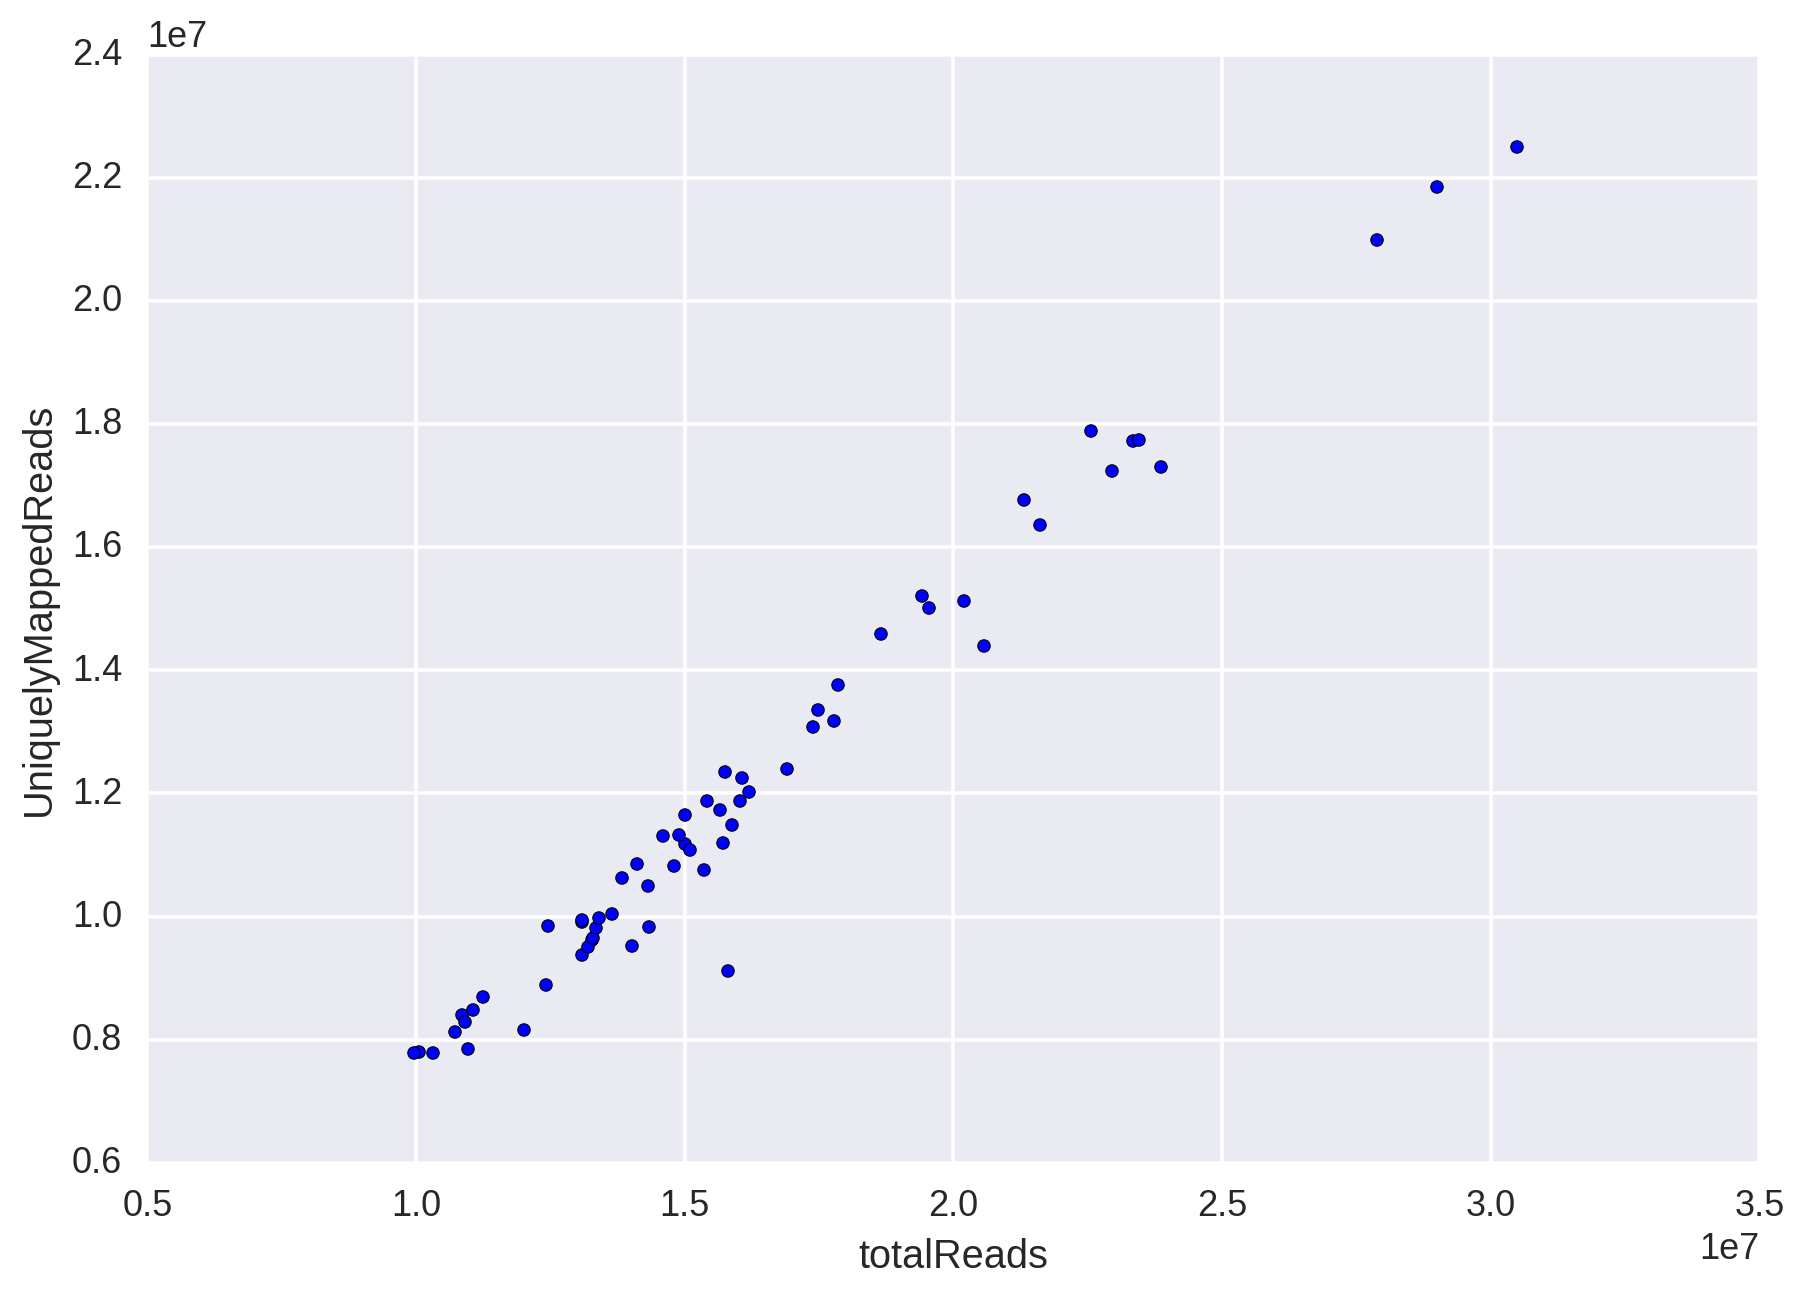

In [31]:
# plot distribution of uniquely mapped reads
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
print(plt.xticks)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
# sns.distplot(filtered_summary_frame['pbc'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
# plt.title('Distribution of PBC (Filtered)')
# plt.xlabel('PBC')
# plt.ylabel('Frequency')
# plt.show()

sns.distplot(filtered_summary_frame['tagsPerPosition'], bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Filtered)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
plt.show()


plt.scatter(filtered_summary_frame['totalReads'], filtered_summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('UniquelyMappedReads')
plt.show()

# plt.boxplot([discarded_summary_frame["spot"], filtered_summary_frame["spot"]])
# plt.xticks([1, 2], ["discarded", "not discarded"])
# plt.ylabel("SPOT")
# plt.show()

# plt.boxplot([discarded_summary_frame["pbc"], filtered_summary_frame["pbc"]])
# plt.ylabel("PBC Coefficient")
# plt.xticks([1, 2], ["discarded", "not discarded"])
# plt.show()

## Peak Calling

In [38]:
veh_input_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-05-20':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-06-29':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-08-18':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/C57Bl6_ThioMac_ChIP_Input_Veh_GFEW_15-08-18/',
                  '15-10-19':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/C57Bl6_ThioMac_ChIP_Input_Veh_GFEW_15-10-19/'
                  
                 }
kla_input_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-05-20':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-06-29':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-08-18':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/C57Bl6_ThioMac_ChIP_Input_KLA-1h_GFEW_15-08-18/',
                  '15-10-19':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/C57Bl6_ThioMac_ChIP_Input_KLA-1h_GFEW_15-10-19/'
                  }
veh_bamInput_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-06-22':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam'
                  }
kla_bamInput_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-06-22':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam'
                  }

### Homer

In [39]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile = open(scratchDirectory + '/peakCalling_homer.sh', 'w')
for tagDir in filtered_summary_frame['originalName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = originalName_cleanedName_dict[tagDir].split("_")
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]

    peakFileName = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    if "veh" in treatment.lower():
        inputDir = veh_input_dict[date]
    elif "kla" in treatment.lower():
            inputDir = kla_input_dict[date]            
    scriptFile.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 100  > ' + 
                     peakDirectory +'/' + peakFileName + ' &\n')
scriptFile.close()




In [ ]:
# ### annotate peaks with tag counts ###
# if not os.path.exists(scratchDirectory):
#     os.mkdir(scratchDirectory)

# scriptFile = open(scratchDirectory + '/homer_peak_annotation.sh', 'w')

# count = 0 
# sleepTime = 0
# peakFiles = os.listdir(peakDirectory)
# for peakFile in peakFiles:
#     if "homer" in peakFile:
#         annotatedFile = peakFile.replace("_homer_peaks.tsv","") + "_homer_annotated.tsv"
#         simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]
#         tagDir1 = cleanedName_originalName_dict[simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]]
#         # annotate peaks with tag counts
#         count += 1
#         if count == 10:
#             count = 0
#             sleepTime += 1
#         scriptFile.write('(sleep ' + str(sleepTime) +'m; annotatePeaks.pl '+
#                          peakDirectory + '/' + peakFile +
#                          ' mm10 -noadj -noann -nogene -d ' +
#                          tagDirPath + '/' + tagDir1 + '> ' +
#                          scratchDirectory + '/' + annotatedFile +') & \n')
# scriptFile.close()

# # run script
# ! bash $scratchDirectory/homer_peak_annotation.sh

In [ ]:
# ### calculate SPOT coefficient
# sampleName_mappedReadsDict = dict(zip(summary_frame['originalName'], summary_frame['totalReads'] - summary_frame['unmappedReads']))
# sampleName_spot_dict = {}
# mappedReadsInPeaks = []
# for p in os.listdir(scratchDirectory):
#     if 'homer_annotated' in p:
#         with open(scratchDirectory + '/' + p) as f:
#             data = f.readlines()
#         simpleName = p.replace('_homer_annotated.tsv','')
#         originalName = simpleName_originalName_dict[simpleName]
#         totalTagCount = 0
#         for line in data[1:]: # first line is head
#             # last column in annotated file gives tag counts
#             tokens = line.strip().split("\t")
#             tagCount = float(tokens[-1])
#             totalTagCount +=tagCount
#             totalMappedReads = sampleName_mappedReadsDict[originalName]
#             spot = totalTagCount/totalMappedReads
#         mappedReadsInPeaks.append(totalTagCount)
#         sampleName_spot_dict[originalName] = spot
# summary_frame['spot'] = [sampleName_spot_dict[x] for x in summary_frame['originalName'].values]

## Run IDR

In [18]:
idrDirectory = '/home/jenhan/analysis/ap1_analysis/ap1_idr/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
homer_peaks = filtered_summary_frame.loc[replicateIndices][['factor', 'simpleTreatment', 'homer_peaks']]
homer_peaks['peak_caller'] = 'homer'
homer_peaks.columns = ['factor', 'simpleTreatment', 'peaks', 'peak_caller']

for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            ! python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory
            

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Performing IDR analysis on the following samples: /home/jenhan/analysis/ap1_analysis/peak_files//c57bl6_atf2_kla_1_peaks.tsv, /home/jenhan/analysis/ap1_analysis/peak_files//c57bl6_atf2_kla_2_peaks.tsv
Output files will be written to: /home/jenhan/analysis/ap1_analysis/ap1_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score'
 'Total Tags (normalized to Control Experiment)' 'Control Tags'
 'Fold Change vs Control' 'p-value vs Control' 'Score']
idr --samples /home/jenhan/analysis/ap1_analysis/ap1_idr//c57bl6_atf2_kla_1_peaks.narrowPeak /home/jenhan/analysis/ap1_analysis/ap1_idr//c57bl6_atf2_kla_2_peaks.narrowPeak --output-file /home

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 20000)

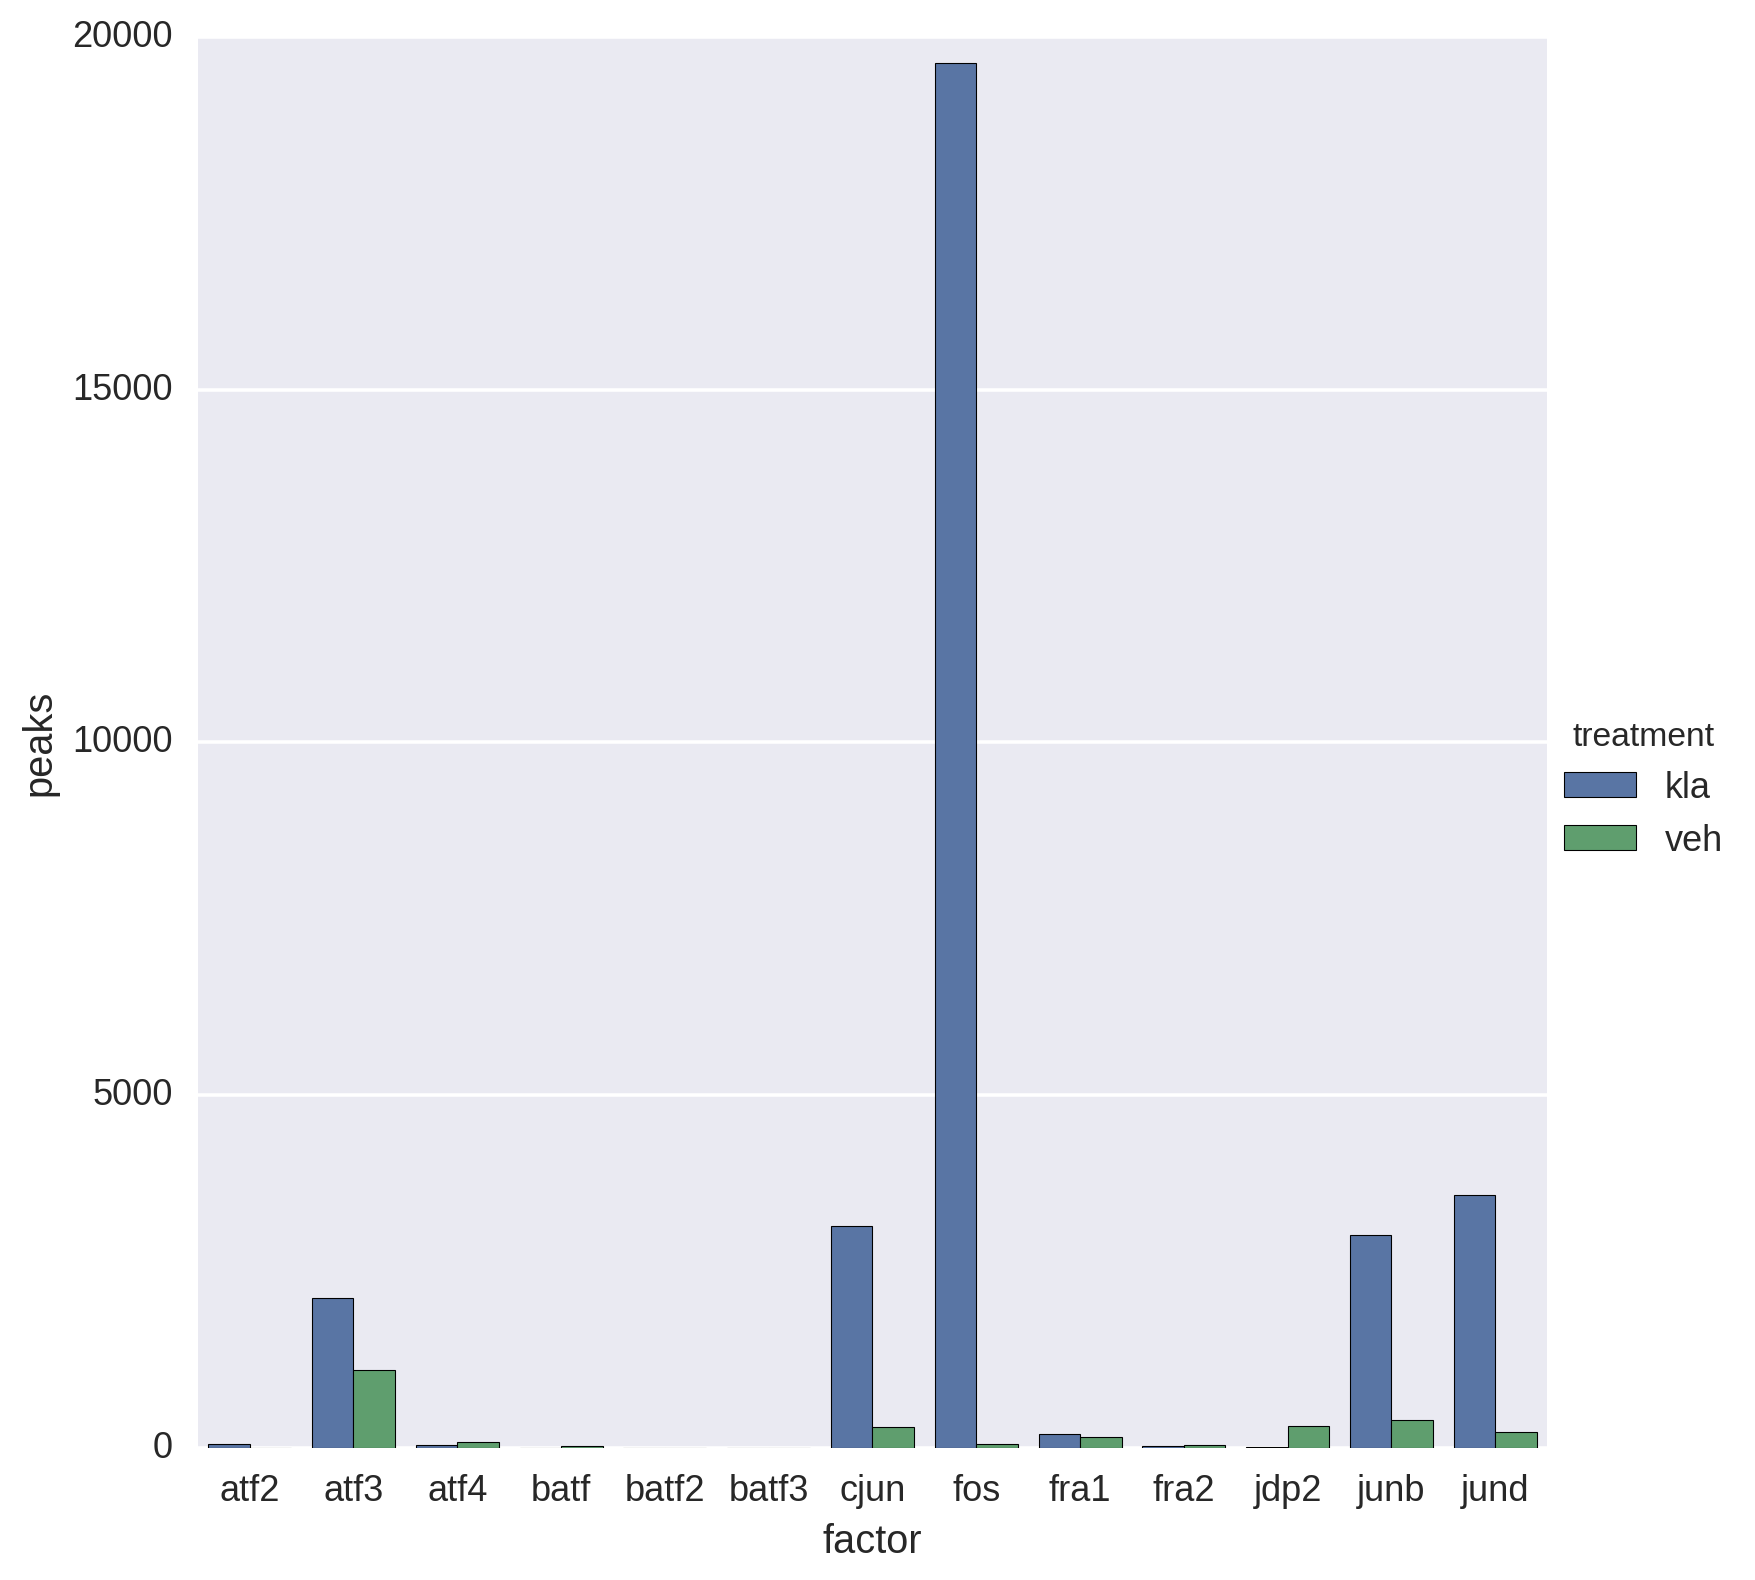

In [8]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jenhan/analysis/ap1_analysis/ap1_idr/'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='treatment', size =8, kind='bar')
plt.ylim([0,20000])
    

In [131]:
! if [ ! -d idrPeaks ]; then mkdir idrPeaks; fi
for key in factorTreatment_bestIDR_dict.keys():
    p = factorTreatment_bestIDR_dict[key]
    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks/' + '_'.join(p.split('_')[1:3]) + '_peaks.tsv'
        ! cp $idrDirectory/$p $outpath
! cp /home/jenhan/analysis/ncor_analysis/peak_files/ncor_notx_peaks.tsv idrPeaks/ncor_veh_peaks.tsv  
! cp /home/jenhan/analysis/ncor_analysis/peak_files/ncor_kla_peaks.tsv idrPeaks/ncor_kla_peaks.tsv  



In [136]:
# create group summary file
!bash /home/jenhan/code/seq_merge_pipe/makeSummaryFile.sh /home/jenhan/analysis/ap1_analysis/idrPeaks/* > /home/jenhan/analysis/ap1_analysis/group_summary.tsv
! cp merged.tsv merged_peaks.tsv

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf3_kla_peaks.tsv (2121 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf3_veh_peaks.tsv (1099 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf4_kla_peaks.tsv (43 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/analysis/ap1_analysis/idrPeaks/atf4_veh_peaks.tsv (78 total)
	Comparing /home/jenhan/analysis/ap1_analysis/idrPeaks/atf2_kla_peaks.tsv (61 total) and /home/jenhan/a

In [228]:
# annotate peaks with enhancer marks
!annotatePeaks.pl /home/jenhan/analysis/ap1_analysis/merged_peaks.tsv mm10 -size 1000 -d tag_directories_enhancerMarks/* > merged_annotated_peaks.tsv


	Peak file = /home/jenhan/analysis/ap1_analysis/merged_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 1000
	Tag Directories:
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_KLA-1h_NJS_10-08-13
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_KLA-1h_NJS_10-09-01
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_notx-1h_NJS_10-08-13
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_notx-1h_NJS_10-09-01
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K27Ac_KLA-1h_CR_12-07-06
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K27Ac_notx_CR_12-07-06
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_KLA-1h_Josh_13-02-07
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_KLA-1h_Josh_14-04-22
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_notx-1h_Josh_13-02-07
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_notx-1h_Josh_14-04-22
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 21906
		Duplicated Peak I

In [14]:
# read in peak data data
summary_frame = pd.read_csv('/home/jenhan/analysis/ap1_analysis/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[4:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
    
summary_frame['chr'] = [x.split(':')[0] for x in summary_frame['Position'].values]
summary_frame['numFactors'] = [len(x.split(',')) for x in summary_frame['Factors'].values]


summary_frame.index = summary_frame['ID'].values
newCols = list(summary_frame.columns.values)[:4] + ['chr', 'numFactors'] + list(summary_frame.columns.values)[4:-2]

summary_frame = summary_frame[newCols]



del summary_frame['Group Number']
del summary_frame['numFactors']

_factors = sorted(set(list(set([x.split('_')[0] for x in summary_frame.columns if '_' in x]))))

columns = summary_frame.columns
for f in _factors:
    if not f + '_veh' in columns:
        summary_frame[f + '_veh'] = [0.0] * summary_frame.shape[0]
    if not f + '_kla' in columns:
        summary_frame[f + '_kla'] = [0.0] * summary_frame.shape[0]

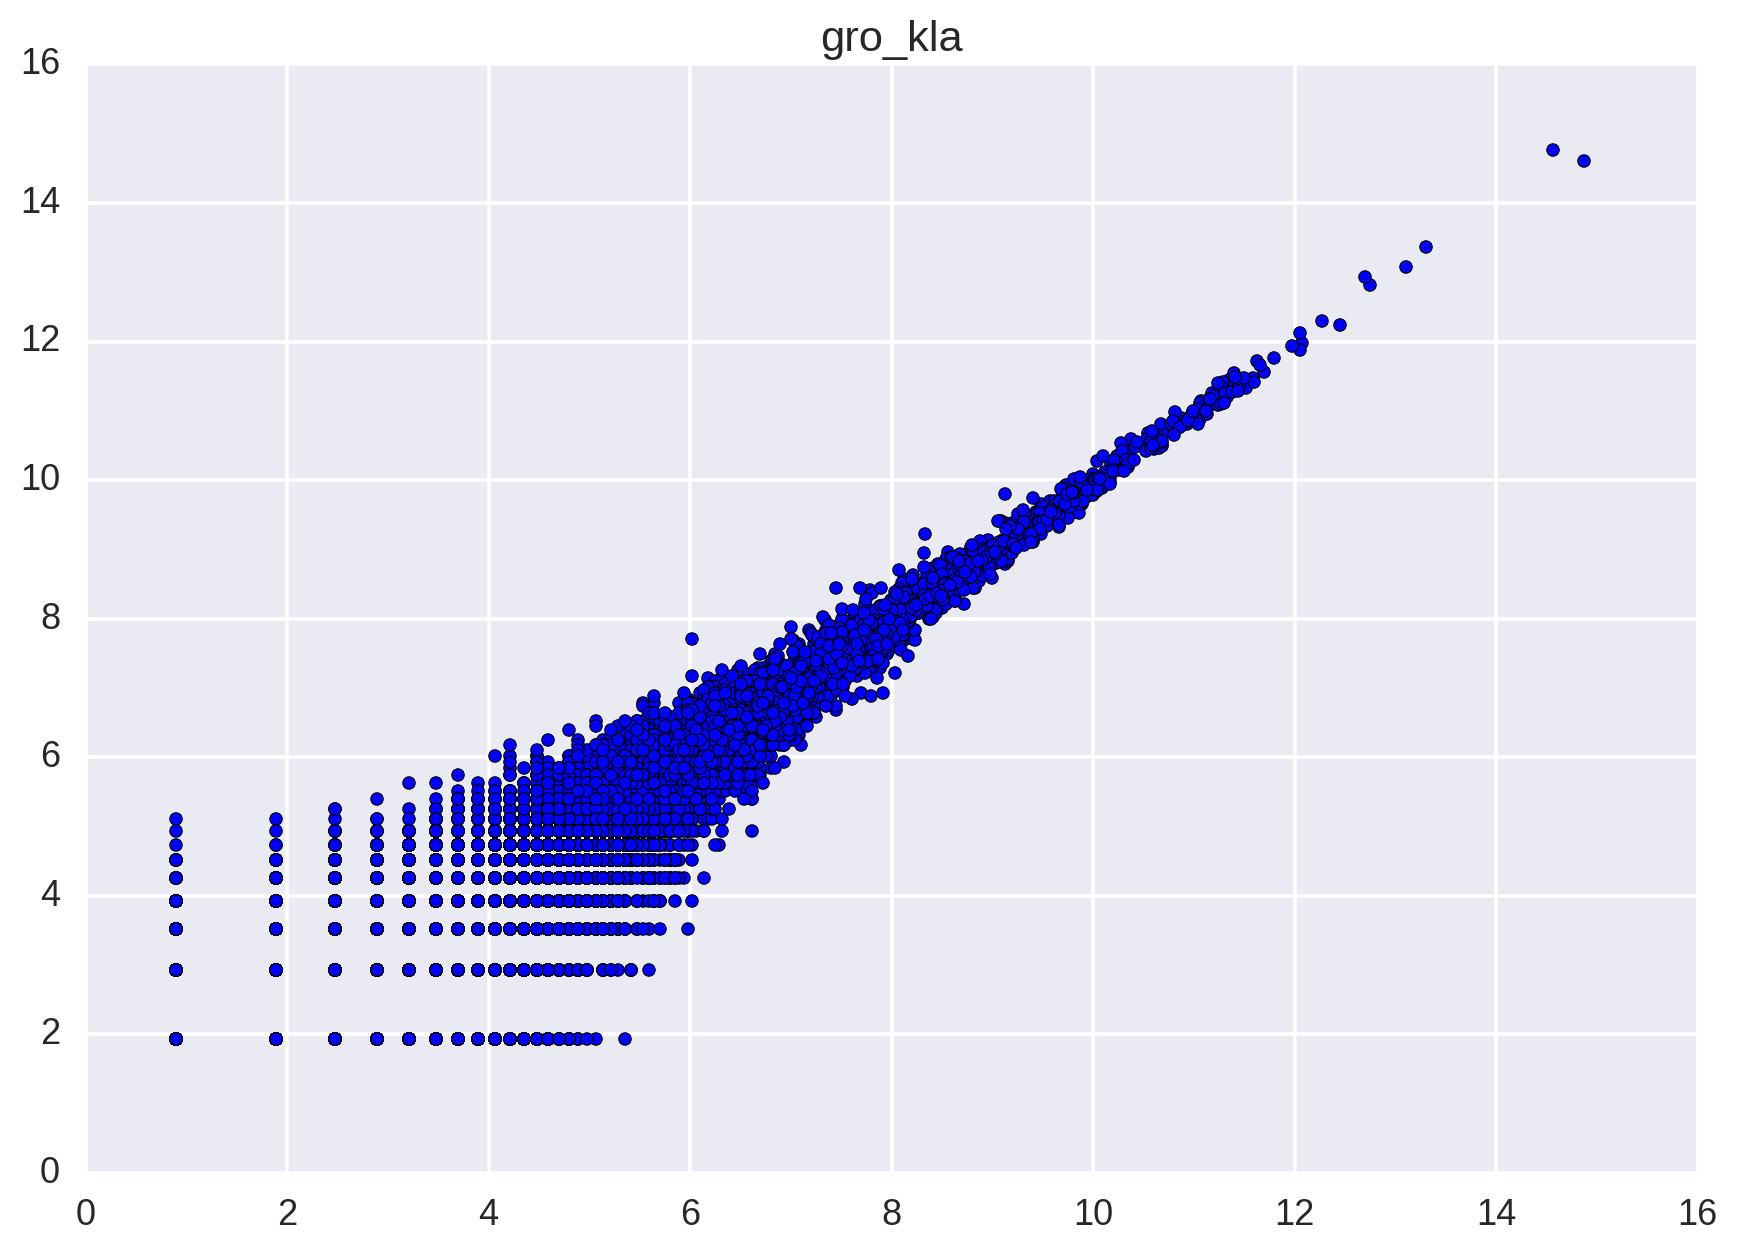

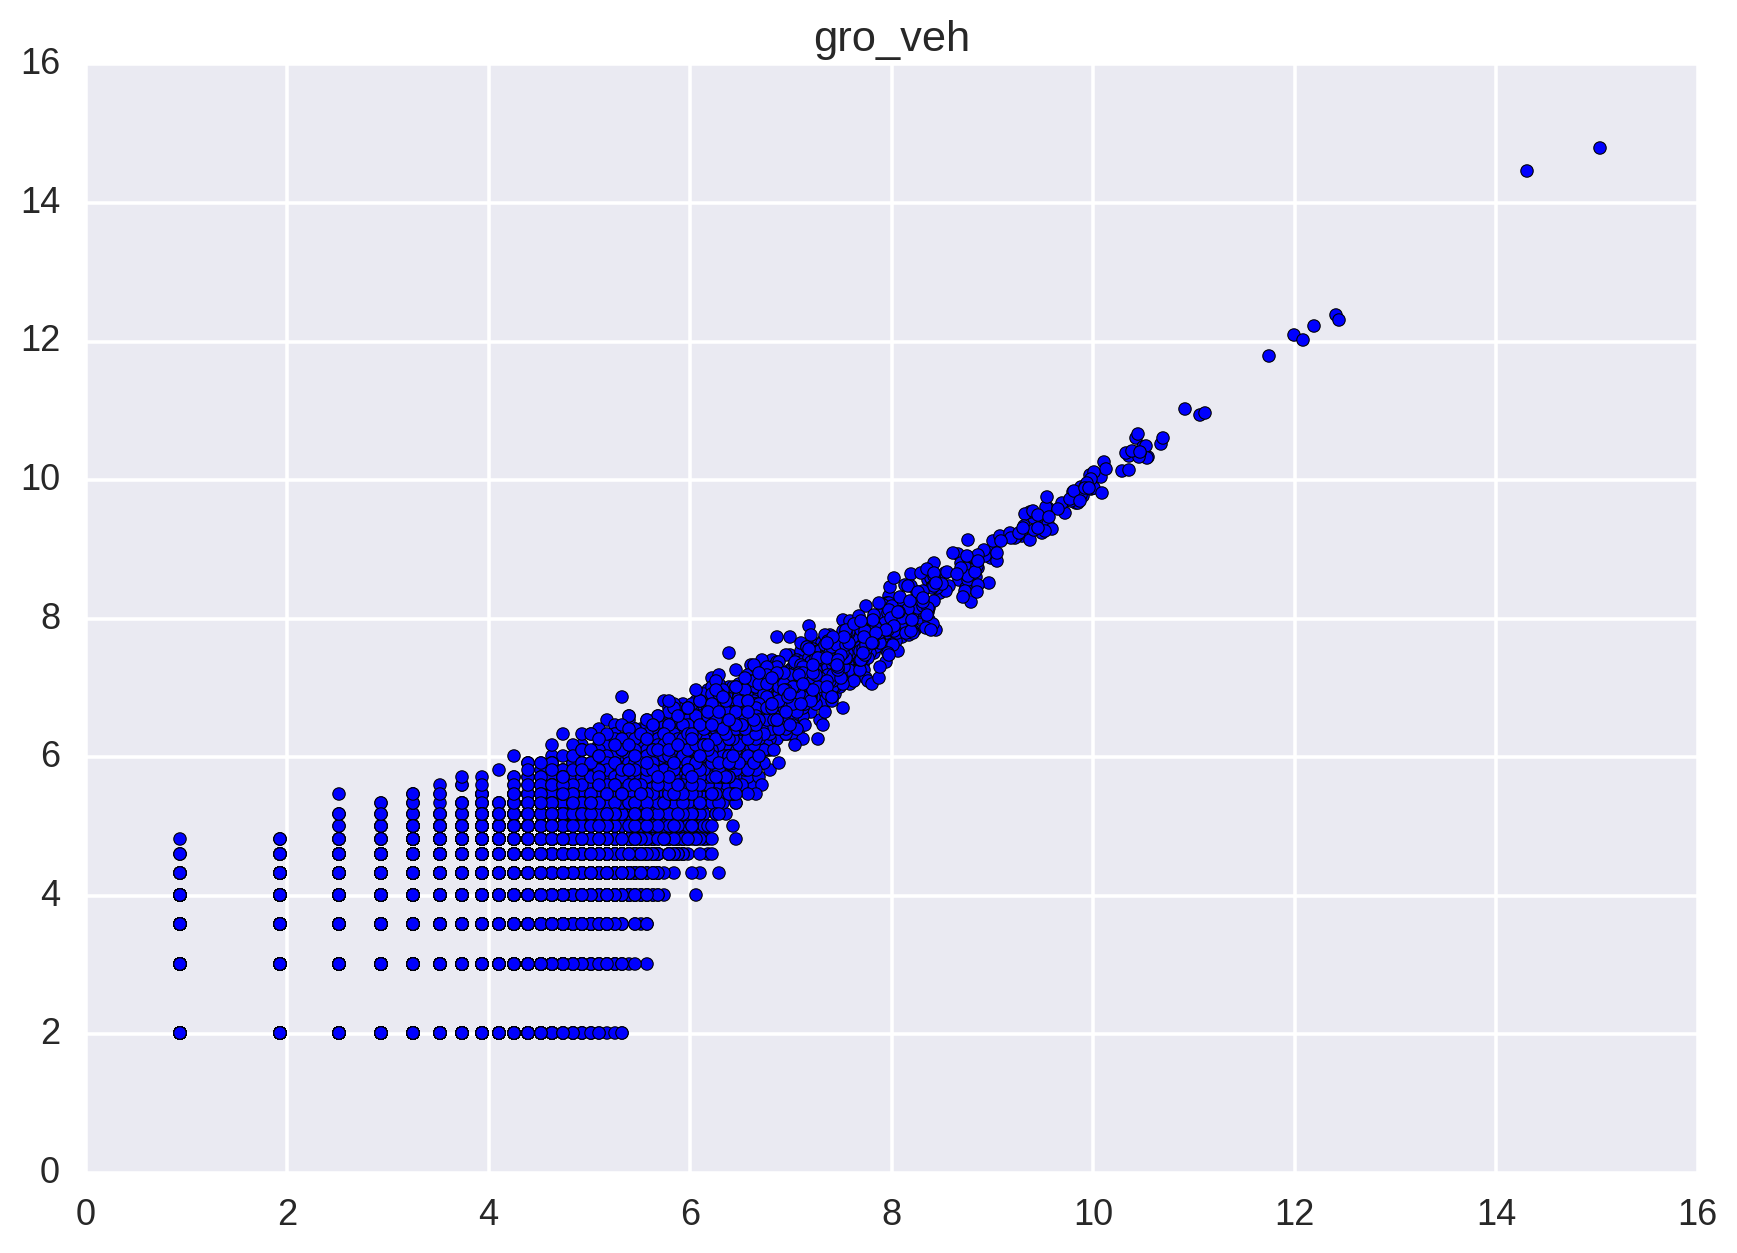

In [21]:
# read in enhancer marks
enhancer_frame = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
enhancer_frame.index=enhancer_frame.ix[:,0].values
for i in [
'Chr',
 'Start',
 'End',
 'Strand',
 'Peak Score',
 'Focus Ratio/Region Size',
 'Detailed Annotation',
 'Distance to TSS',
 'Nearest PromoterID',
 'Entrez ID',
 'Nearest Unigene',
 'Nearest Refseq',
 'Nearest Ensembl',
 'Gene Name',
 'Gene Alias',
 'Gene Description',
 'Gene Type']:
    del enhancer_frame[i]
columns = enhancer_frame.columns.values

columns[0] = 'ID'

# drop bad H3K4me1 samples
columns = [x for x in columns if not 'Josh_13-02-07' in x]
enhancer_frame = enhancer_frame[columns]

columns = ['_'.join(x.split('/')[1].split()[0].replace('-1h','').split('_')[2:4]) if '/' in x else x for x in columns]

# change notx and KLA to veh and kla
columns = [x.lower().replace('notx', 'veh') if '_' in x else x for x in columns]
enhancer_frame.columns = columns

# clean up annotations
enhancer_frame['Annotation'] = [x.split('(')[0].strip() for x in enhancer_frame['Annotation'].values]



# summary_frame = summary_frame.merge(data_frame, on='ID')

_enhancerMarks = sorted(list(set(enhancer_frame.columns.values[2:])))

# make scatter plots for all marks that have a replicate
for em in _enhancerMarks:
    if len(enhancer_frame[em].shape) > 1:
        toPlot=enhancer_frame[em]
        plt.scatter(np.log2(toPlot.ix[:,0]), np.log2(toPlot.ix[:,1]))
        plt.title(em)
        plt.show()

# average the values of replicates
for em in _enhancerMarks:
    if len(enhancer_frame[em].shape) > 1:
        vals = np.mean(enhancer_frame[em], axis=1)
        del enhancer_frame[em]
        enhancer_frame[em] = vals
        
# remove outlier GRO-seq values
enhancer_frame.loc[enhancer_frame['gro_veh'] > 10000, 'gro_veh' ] = 0
enhancer_frame.loc[enhancer_frame['gro_kla'] > 10000, 'gro_kla' ] = 0

In [22]:
sns.set_context('talk', font_scale=0.6)
id_annotation_dict = dict(zip(enhancer_frame['ID'].values, enhancer_frame['Annotation'].values))
annotationTypes = set(enhancer_frame['Annotation'].values)
pie_color_dict = dict(zip(annotationTypes, sns.color_palette('colorblind', len(annotationTypes))))
hf, ha = plt.subplots(1,3)

for f in _factors:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    
    # for veh
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in veh_ids]
    plt.subplot(1,3,1)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' veh (' + str(len(annotations)) +' peaks)')        
        plt.axis('equal')
    else:
        ha[0].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    # for shared peaks
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in shared_ids]
    plt.subplot(1,3,2)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' shared (' + str(len(annotations)) +' peaks)')
        plt.axis('equal')
    else:
        ha[1].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    
    # for KLA
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in kla_ids]
    plt.subplot(1,3,3)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' kla (' + str(len(annotations)) +' peaks)')        
        plt.axis('equal')
    else:
        ha[2].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    plt.savefig(f + '_annotationPie.png')
    plt.close()
sns.set_context('talk', font_scale=1.0)    

In [23]:
# plot enhancer mark boxplots
# colors = []
# for i in sns.color_palette('colorblind',8):
#     colors.append(i)
#     colors.append(i)
sns.set_context('talk', font_scale=0.6)
colors = sns.color_palette('Paired',8)
p_threshold = 0.05

for f in _factors:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = enhancer_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    id_lists = [veh_ids, shared_ids, kla_ids]
    id_names = ['veh', 'shared', 'kla']

    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,1)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        ### h3k27ac
        veh_values = enhancer_frame.ix[ids,'h3k27ac_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k27ac_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' H3K27Ac Tag Counts')
    ### for h3k4me1
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,2)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'h3k4me1_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k4me1_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' h3k4me1 Tag Counts')
    
    # for Gro seq
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,3)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'gro_veh'].values
        kla_values = enhancer_frame.ix[ids,'gro_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' GRO-seq Tag Counts')
    plt.savefig(f+ "_enhancerMarks.png")
    plt.close()
sns.set_context('talk', font_scale=1.0)



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1712: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1712: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


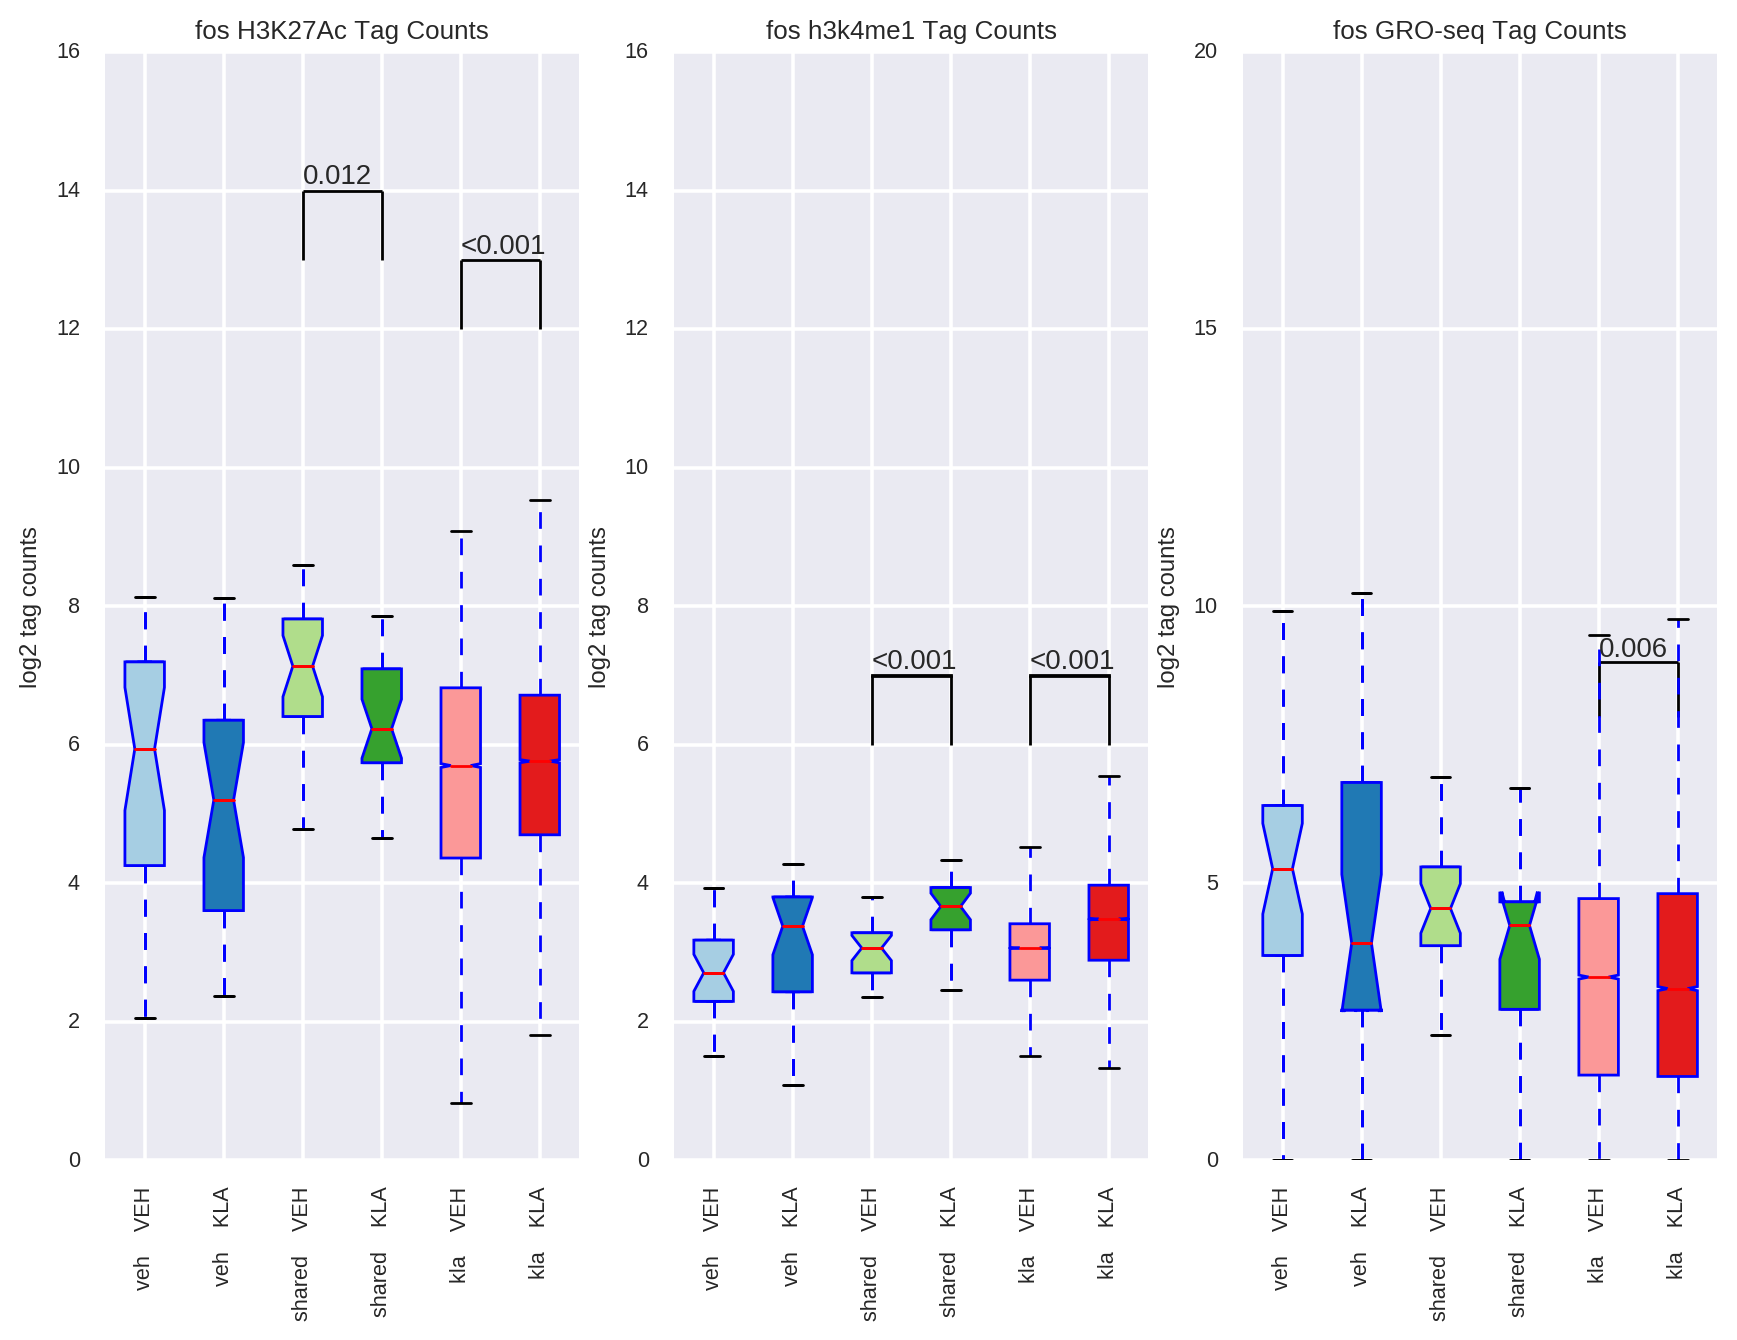

In [24]:
# plot enhancer mark boxplots
# colors = []
# for i in sns.color_palette('colorblind',8):
#     colors.append(i)
#     colors.append(i)
sns.set_context('talk', font_scale=0.6)
colors = sns.color_palette('Paired',8)
p_threshold = 0.05

for f in ['fos']:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = enhancer_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    id_lists = [veh_ids, shared_ids, kla_ids]
    id_names = ['veh', 'shared', 'kla']

    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,1)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        ### h3k27ac
        veh_values = enhancer_frame.ix[ids,'h3k27ac_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k27ac_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' H3K27Ac Tag Counts')
    ### for h3k4me1
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,2)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'h3k4me1_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k4me1_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' h3k4me1 Tag Counts')
    
    # for Gro seq
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,3)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'gro_veh'].values
        kla_values = enhancer_frame.ix[ids,'gro_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,20])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' GRO-seq Tag Counts')
    plt.show()
    plt.close()
sns.set_context('talk', font_scale=1.0)




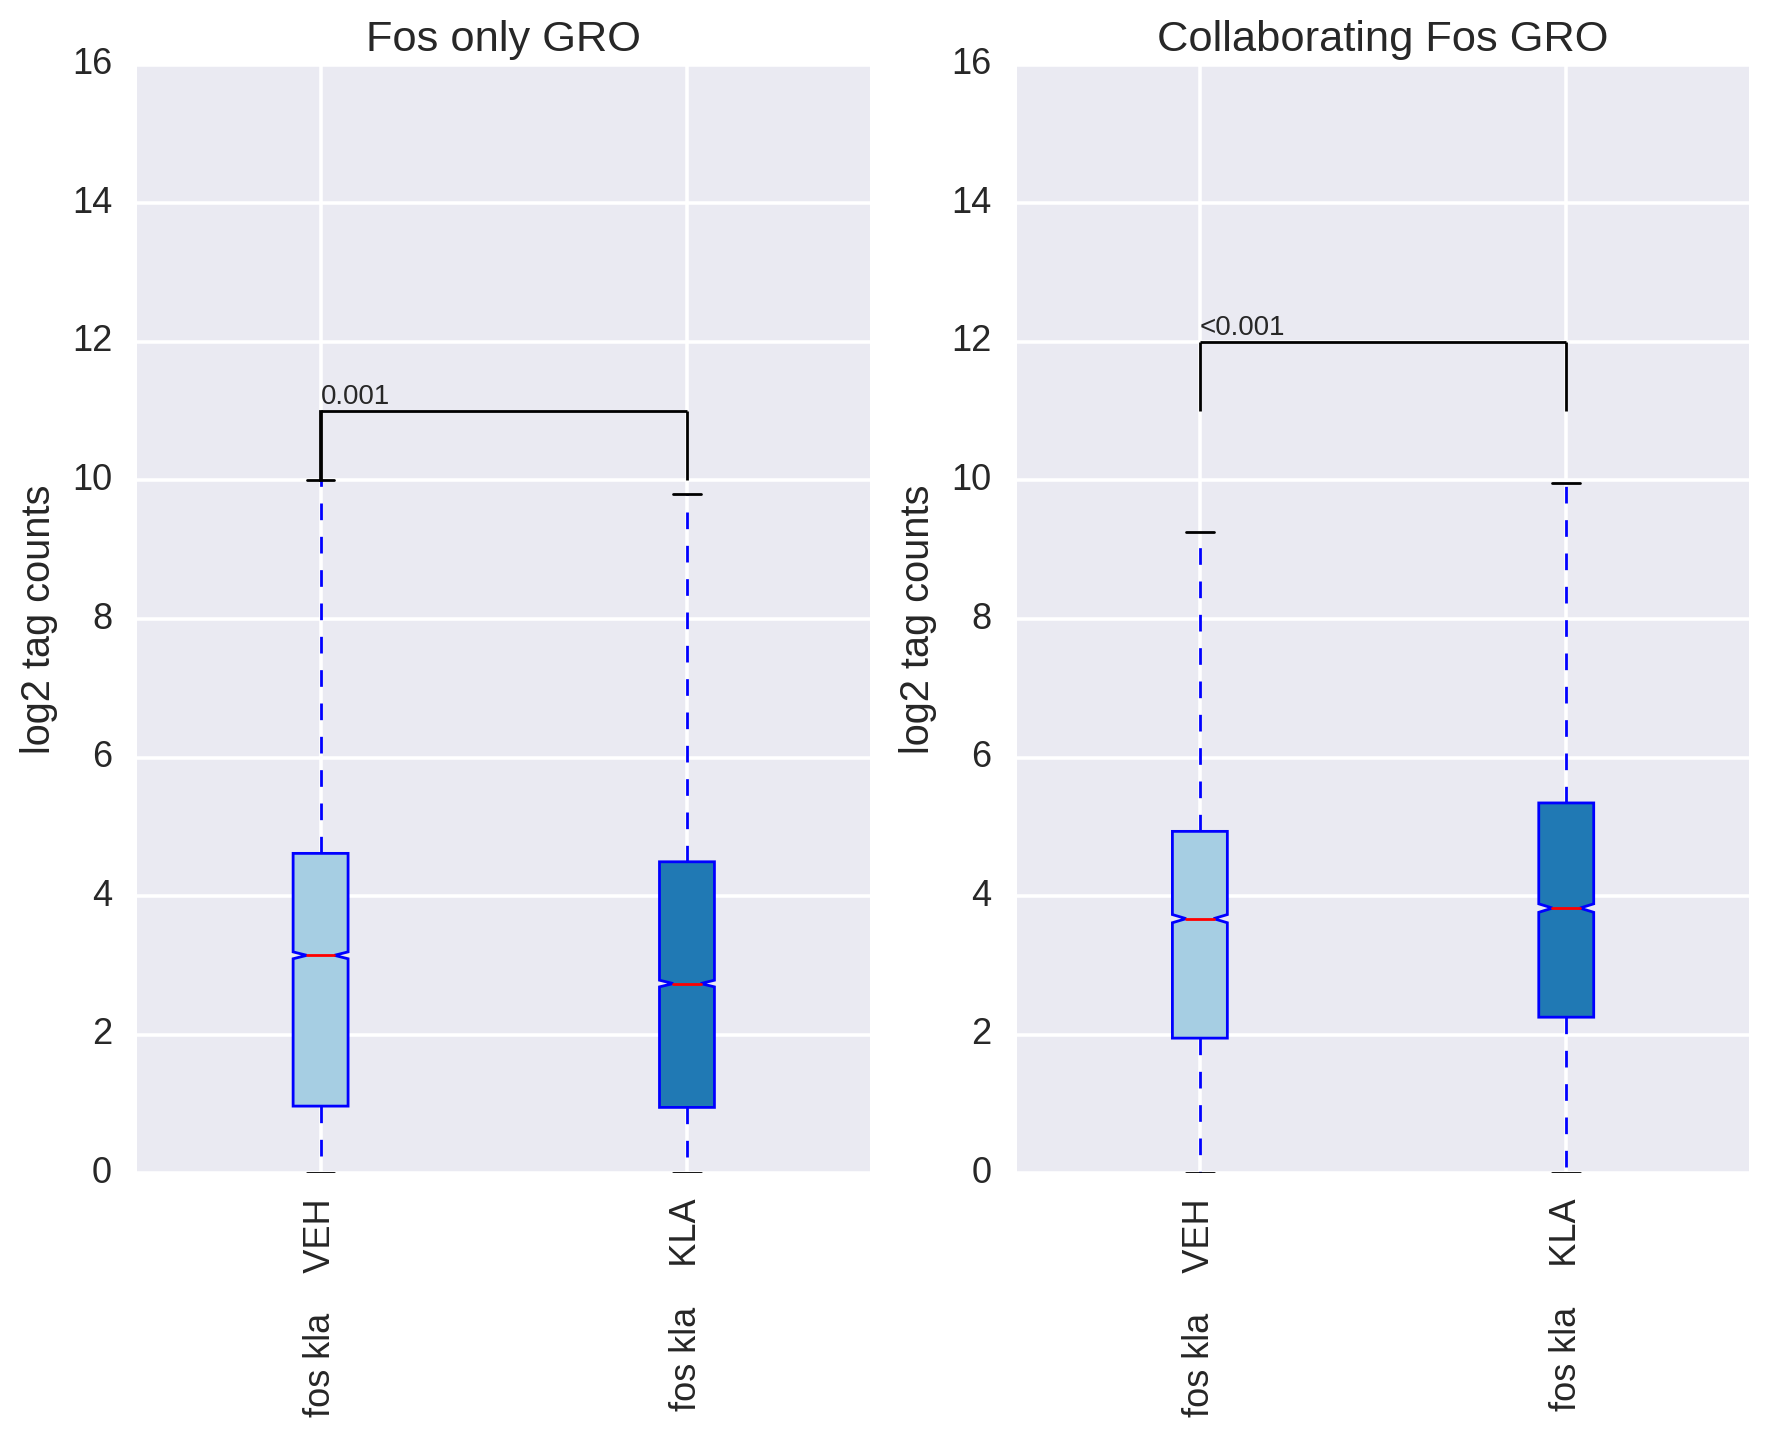

In [25]:
fos_only_ids = summary_frame[summary_frame.sum(axis=1)==summary_frame['fos_kla']]['ID'].values

counts = []
labels = []
pvals = []
plt.subplot(1,2,1)
veh_values = enhancer_frame.ix[fos_only_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_only_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('Fos only GRO')

fos_collaborating_ids = summary_frame[(summary_frame.sum(axis=1)!=summary_frame['fos_kla']) & (summary_frame['fos_kla'] > 0)]['ID'].values
counts = []
labels = []
pvals = []
plt.subplot(1,2,2)
ids = fos_only_ids
veh_values = enhancer_frame.ix[fos_collaborating_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('Collaborating Fos GRO')


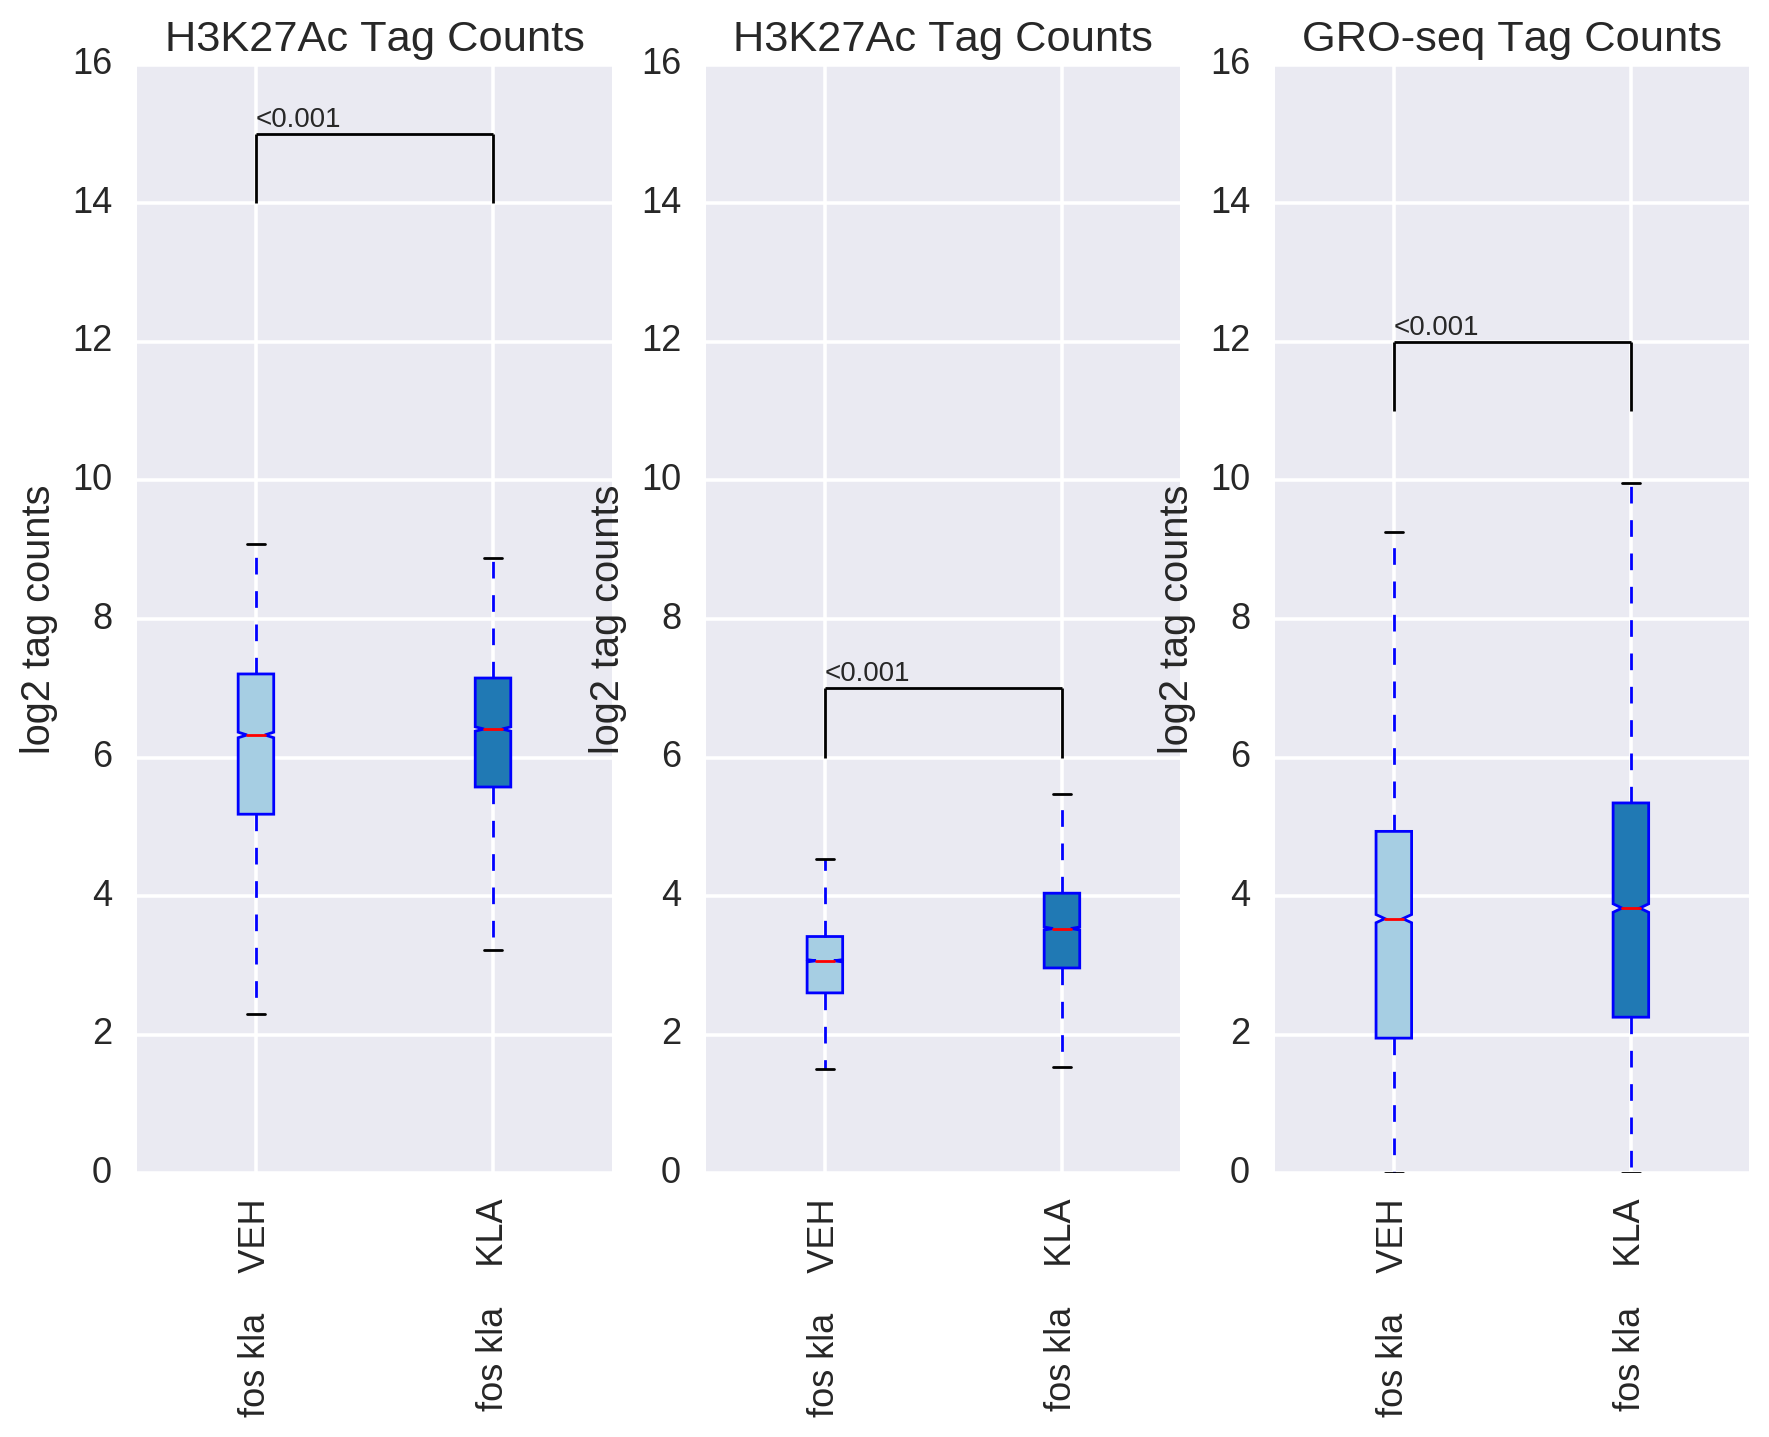

In [26]:
fos_collaborating_ids = summary_frame[(summary_frame.sum(axis=1)!=summary_frame['fos_kla']) & (summary_frame['fos_kla'] > 0)]['ID'].values

counts = []
labels = []
pvals = []
plt.subplot(1,3,1)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'h3k27ac_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'h3k27ac_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')



counts = []
labels = []
pvals = []
plt.subplot(1,3,2)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'h3k4me1_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'h3k4me1_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')


counts = []
labels = []
pvals = []
plt.subplot(1,3,3)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('GRO-seq Tag Counts')



In [41]:
filtered_summary_frame[['sampleName','simplifiedName','uniquelyMappedFraction', 'uniquelyMappedReads', 'totalReads']]

sampleName  \
C57Bl6 ATF2  kla   C57Bl6_ThioMac_ChIP_ATF2_KLA-1h_GJF_14-08-07   
             kla   C57Bl6_ThioMac_ChIP_ATF2_KLA-1h_GJF_15-02-06   
             veh      C57Bl6_ThioMac_ChIP_ATF2_Veh_GJF_14-08-07   
             veh      C57Bl6_ThioMac_ChIP_ATF2_Veh_GJF_15-02-06   
       ATF3  kla   C57Bl6_ThioMac_ChIP_ATF3_KLA-1h_GJF_14-08-07   
             kla  C57Bl6_ThioMac_ChIP_ATF3_KLA-1h_GFEW_15-08-18   
             kla   C57Bl6_ThioMac_ChIP_ATF3_KLA-1h_GJF_15-02-06   
             veh      C57Bl6_ThioMac_ChIP_ATF3_Veh_GJF_15-06-29   
             veh     C57Bl6_ThioMac_ChIP_ATF3_Veh_GFEW_15-08-18   
             veh      C57Bl6_ThioMac_ChIP_ATF3_Veh_GJF_14-08-07   
       ATF4  kla  C57Bl6_ThioMac_ChIP_ATF4_KLA-1h_GFEW_15-08-18   
             kla   C57Bl6_ThioMac_ChIP_ATF4_KLA-1h_GJF_14-08-07   
             veh      C57Bl6_ThioMac_ChIP_ATF4_Veh_GJF_14-08-07   
             veh     C57Bl6_ThioMac_ChIP_ATF4_Veh_GFEW_15-08-18   
             veh      C57Bl6_ThioMac_ChIP_ATF4_Veh_GJF_15-06-29   
       Batf  kla  C57Bl6_ThioMac_ChIP_Batf_KLA-1h_GFEW_15-08-18   
             kla   C57Bl6_ThioMac_ChIP_Batf_KLA-1h_GJF_15-02-06   
             veh     C57Bl6_ThioMac_ChIP_Batf_Veh_GFEW_15-08-18   
             veh      C57Bl6_ThioMac_ChIP_Batf_Veh_GJF_15-02-06   
       Batf2 kla  C57Bl6_ThioMac_ChIP_Batf2_KLA-1h_GJF_14-08-07   
             kla  C57Bl6_ThioMac_ChIP_Batf2_KLA-1h_GJF_15-02-06   
             veh     C57Bl6_ThioMac_ChIP_Batf2_Veh_GJF_15-02-06   
             veh     C57Bl6_ThioMac_ChIP_Batf2_Veh_GJF_14-08-07   
       Batf3 kla  C57Bl6_ThioMac_ChIP_Batf3_KLA-1h_GJF_14-08-07   
             kla  C57Bl6_ThioMac_ChIP_Batf3_KLA-1h_GJF_15-02-06   
             veh     C57Bl6_ThioMac_ChIP_Batf3_Veh_GJF_14-08-07   
             veh     C57Bl6_ThioMac_ChIP_Batf3_Veh_GJF_15-02-06   
       Fos   kla    C57Bl6_ThioMac_ChIP_Fos_KLA-1h_GJF_15-02-06   
             kla    C57Bl6_ThioMac_ChIP_Fos_KLA-1h_GJF_14-03-17   
             kla    C57Bl6_ThioMac_ChIP_Fos_KLA-1h_GJF_15-05-20   
...                                                         ...   
       Fra1  kla   C57Bl6_ThioMac_ChIP_Fra1_KLA-1h_GJF_14-03-17   
             kla   C57Bl6_ThioMac_ChIP_Fra1_KLA-1h_GJF_15-02-06   
             kla  C57Bl6_ThioMac_ChIP_Fra1_KLA-1h_GFEW_15-08-18   
             veh      C57Bl6_ThioMac_ChIP_Fra1_Veh_GJF_14-03-17   
             veh     C57Bl6_ThioMac_ChIP_Fra1_Veh_GFEW_15-08-18   
             veh      C57Bl6_ThioMac_ChIP_Fra1_Veh_GJF_15-02-06   
       Fra2  kla   C57Bl6_ThioMac_ChIP_Fra2_KLA-1h_GJF_15-02-06   
             kla  C57Bl6_ThioMac_ChIP_Fra2_KLA-1h_GFEW_15-08-18   
             veh     C57Bl6_ThioMac_ChIP_Fra2_Veh_GFEW_15-08-18   
             veh      C57Bl6_ThioMac_ChIP_Fra2_Veh_GJF_15-02-06   
       Jdp2  kla   C57Bl6_ThioMac_ChIP_Jdp2_KLA-1h_GJF_15-02-06   
             kla  C57Bl6_ThioMac_ChIP_Jdp2_KLA-1h_GFEW_15-08-18   
             veh      C57Bl6_ThioMac_ChIP_Jdp2_Veh_GJF_14-03-17   
             veh      C57Bl6_ThioMac_ChIP_Jdp2_Veh_GJF_15-02-06   
             veh      C57Bl6_ThioMac_ChIP_Jdp2_Veh_GJF_15-06-29   
             veh     C57Bl6_ThioMac_ChIP_Jdp2_Veh_GFEW_15-08-18   
       JunB  kla   C57Bl6_ThioMac_ChIP_JunB_KLA-1h_GJF_15-05-20   
             kla   C57Bl6_ThioMac_ChIP_JunB_KLA-1h_GJF_15-02-06   
             veh      C57Bl6_ThioMac_ChIP_JunB_Veh_GJF_15-02-06   
             veh      C57Bl6_ThioMac_ChIP_JunB_Veh_GJF_15-05-20   
       JunD  kla   C57Bl6_ThioMac_ChIP_JunD_KLA-1h_GJF_15-05-20   
             kla   C57Bl6_ThioMac_ChIP_JunD_KLA-1h_GJF_14-03-17   
             kla   C57Bl6_ThioMac_ChIP_JunD_KLA-1h_GJF_15-02-06   
             veh      C57Bl6_ThioMac_ChIP_JunD_Veh_GJF_15-05-20   
             veh      C57Bl6_ThioMac_ChIP_JunD_Veh_GJF_15-02-06   
             veh      C57Bl6_ThioMac_ChIP_JunD_Veh_GJF_14-03-17   
       cJun  kla   C57Bl6_ThioMac_ChIP_cJun_KLA-1h_GJF_15-05-20   
             kla   C57Bl6_ThioMac_ChIP_cJun_KLA-1h_GJF_15-02-06   
             veh      C57Bl6_Thio